<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [607]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [608]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [609]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [610]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [611]:
#df=pd.read_excel("BG_Dataset/BG_sample27.xlsx")

In [612]:
# Colab
df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_sample1.xlsx")
#df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Sample46.csv")


In [613]:
df.shape

(1055, 14)

In [614]:
df.head(13)

색인 타임스탬프(YYYY-MM-DDThh:mm:ss) 이벤트 유형 이벤트 하위 유형                환자 정보  \
0    1                        NaN     이름       NaN                  sch   
1    2                        NaN      성       NaN                    s   
2    3                        NaN   생년월일       NaN  1990-01-01 00:00:00   
3    4                        NaN     장치       NaN                  NaN   
4    5                        NaN     경고        하락                  NaN   
5    6                        NaN     경고        높음                  NaN   
6    7                        NaN     경고        낮음                  NaN   
7    8                        NaN     경고     신호 손실                  NaN   
8    9                        NaN     경고        상승                  NaN   
9   10                        NaN     경고     매우 낮음                  NaN   
10  11        2019-05-07T16:07:41     교정       NaN                  NaN   
11  12        2019-05-07T16:07:54     교정       NaN                  NaN   
12  13        2019-05-07T16:12:56    EGV       NaN                  NaN   

                   장치 정보 소스 장치 ID  포도당 값 (mg/dL)  인슐린 값(u)  탄수화물 값 (그램)  \
0                    NaN      NaN            NaN       NaN          NaN   
1                    NaN      NaN            NaN       NaN          NaN   
2                    NaN      NaN            NaN       NaN          NaN   
3   Dexcom G5 Mobile App  Android            NaN       NaN          NaN   
4                    NaN  Android            NaN       NaN          NaN   
5                    NaN  Android          400.0       NaN          NaN   
6                    NaN  Android           60.0       NaN          NaN   
7                    NaN  Android            NaN       NaN          NaN   
8                    NaN  Android            NaN       NaN          NaN   
9                    NaN  Android           55.0       NaN          NaN   
10                   NaN  Android          120.0       NaN          NaN   
11                   NaN  Android          120.0       NaN          NaN   
12                   NaN  Android          115.0       NaN          NaN   

   기간(hh:mm:ss)  포도당 변화율 (mg/dL/min)  트랜스미터 시간 (배장 정수) 트랜스미터 ID  
0           NaN                  NaN               NaN      NaN  
1           NaN                  NaN               NaN      NaN  
2           NaN                  NaN               NaN      NaN  
3           NaN                  NaN               NaN      NaN  
4           NaN                  3.0               NaN      NaN  
5           NaN                  NaN               NaN      NaN  
6           NaN                  NaN               NaN      NaN  
7      00:30:00                  NaN               NaN      NaN  
8           NaN                  3.0               NaN      NaN  
9           NaN                  NaN               NaN      NaN  
10          NaN                  NaN               NaN   40EPTP  
11          NaN                  NaN               NaN   40EPTP  
12          NaN                  NaN         1836247.0   40EPTP

In [615]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [616]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [617]:
df['Event'].value_counts()

EGV     1031
교정        14
경고         6
장치         1
생년월일       1
이름         1
성          1
Name: Event, dtype: int64

In [618]:
df['Glucose'].value_counts()

160.0    25
133.0    23
144.0    18
142.0    17
163.0    17
         ..
338.0     1
229.0     1
305.0     1
399.0     1
243.0     1
Name: Glucose, Length: 223, dtype: int64

In [619]:
df.tail()

Timestamp Event  Glucose  Insulin  Meal
1050  2019-05-11T23:42:33   EGV    206.0      NaN   NaN
1051  2019-05-11T23:47:34   EGV    199.0      NaN   NaN
1052  2019-05-11T23:52:33   EGV    190.0      NaN   NaN
1053  2019-05-11T23:57:33   EGV    194.0      NaN   NaN
1054  2019-05-12T00:02:33   EGV    181.0      NaN   NaN

In [620]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

Series([], Name: Insulin, dtype: int64)

In [621]:
# 식사 횟수
df['Meal'].value_counts()

Series([], Name: Meal, dtype: int64)

In [622]:
df.head(15)

Timestamp Event  Glucose  Insulin  Meal
0                   NaN    이름      NaN      NaN   NaN
1                   NaN     성      NaN      NaN   NaN
2                   NaN  생년월일      NaN      NaN   NaN
3                   NaN    장치      NaN      NaN   NaN
4                   NaN    경고      NaN      NaN   NaN
5                   NaN    경고    400.0      NaN   NaN
6                   NaN    경고     60.0      NaN   NaN
7                   NaN    경고      NaN      NaN   NaN
8                   NaN    경고      NaN      NaN   NaN
9                   NaN    경고     55.0      NaN   NaN
10  2019-05-07T16:07:41    교정    120.0      NaN   NaN
11  2019-05-07T16:07:54    교정    120.0      NaN   NaN
12  2019-05-07T16:12:56   EGV    115.0      NaN   NaN
13  2019-05-07T16:17:47   EGV    126.0      NaN   NaN
14  2019-05-07T16:22:47   EGV    135.0      NaN   NaN

In [623]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [624]:
df.head(20)

Timestamp Event  Glucose  Insulin  Meal
10  2019-05-07T16:07:41    교정    120.0      NaN   NaN
11  2019-05-07T16:07:54    교정    120.0      NaN   NaN
12  2019-05-07T16:12:56   EGV    115.0      NaN   NaN
13  2019-05-07T16:17:47   EGV    126.0      NaN   NaN
14  2019-05-07T16:22:47   EGV    135.0      NaN   NaN
15  2019-05-07T16:27:48   EGV    139.0      NaN   NaN
16  2019-05-07T16:32:48   EGV    143.0      NaN   NaN
17  2019-05-07T16:37:48   EGV    150.0      NaN   NaN
18  2019-05-07T16:42:48   EGV    156.0      NaN   NaN
19  2019-05-07T16:47:47   EGV    150.0      NaN   NaN
20  2019-05-07T16:52:48   EGV    144.0      NaN   NaN
21  2019-05-07T16:57:47   EGV    144.0      NaN   NaN
22  2019-05-07T17:02:47   EGV    134.0      NaN   NaN
23  2019-05-07T17:07:47   EGV    120.0      NaN   NaN
24  2019-05-07T17:12:47   EGV    113.0      NaN   NaN
25  2019-05-07T17:17:47   EGV    106.0      NaN   NaN
26  2019-05-07T17:22:47   EGV    101.0      NaN   NaN
27  2019-05-07T17:27:46   EGV     94.0      NaN   NaN
28  2019-05-07T17:32:47   EGV     90.0      NaN   NaN
29  2019-05-07T17:37:47   EGV     88.0      NaN   NaN

In [625]:
df.shape

(1045, 5)

In [626]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [627]:
df.head(15)

Timestamp Event  Glucose  Insulin  Meal
0   2019-05-07T16:07:41    교정    120.0      NaN   NaN
1   2019-05-07T16:07:54    교정    120.0      NaN   NaN
2   2019-05-07T16:12:56   EGV    115.0      NaN   NaN
3   2019-05-07T16:17:47   EGV    126.0      NaN   NaN
4   2019-05-07T16:22:47   EGV    135.0      NaN   NaN
5   2019-05-07T16:27:48   EGV    139.0      NaN   NaN
6   2019-05-07T16:32:48   EGV    143.0      NaN   NaN
7   2019-05-07T16:37:48   EGV    150.0      NaN   NaN
8   2019-05-07T16:42:48   EGV    156.0      NaN   NaN
9   2019-05-07T16:47:47   EGV    150.0      NaN   NaN
10  2019-05-07T16:52:48   EGV    144.0      NaN   NaN
11  2019-05-07T16:57:47   EGV    144.0      NaN   NaN
12  2019-05-07T17:02:47   EGV    134.0      NaN   NaN
13  2019-05-07T17:07:47   EGV    120.0      NaN   NaN
14  2019-05-07T17:12:47   EGV    113.0      NaN   NaN

In [628]:
df.shape

(1045, 5)

In [629]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [630]:
def isNaN(num):
    return num==num

In [631]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [632]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [633]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [634]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [635]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [636]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [637]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [638]:
glucose_count_high(df,'Glucose')

높음 :  0


In [639]:
print('높음 개수 :',len(high_list))

높음 개수 : 0


In [640]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [641]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [642]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [643]:
low_list

[]

In [644]:
calibration_count_low(df,'Event')

교정 :  14


In [645]:
calib_list

[0, 1, 58, 173, 287, 349, 470, 579, 639, 751, 874, 950, 952, 1015]

In [646]:
insul_count(df,'Insulin')

인슐린 :  0


In [647]:
insulin_list

[]

In [648]:
meal_count(df,'Meal')

식사 횟수 :  0


In [649]:
meal_list

[]

In [650]:
df['Insulin'].value_counts()

Series([], Name: Insulin, dtype: int64)

In [651]:
df['Meal'].value_counts()

Series([], Name: Meal, dtype: int64)

In [652]:
isNaN(df['Glucose'][14])

True

In [653]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [654]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [655]:
import math
math.isnan(df['Glucose'][14])

False

In [656]:
insulin_list

[]

In [657]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [658]:
insulin_list

[]

In [659]:
df=df.drop(insulin_list)

In [660]:
df[10:20]

Timestamp Event  Glucose  Insulin  Meal
10  2019-05-07T16:52:48   EGV    144.0      NaN   NaN
11  2019-05-07T16:57:47   EGV    144.0      NaN   NaN
12  2019-05-07T17:02:47   EGV    134.0      NaN   NaN
13  2019-05-07T17:07:47   EGV    120.0      NaN   NaN
14  2019-05-07T17:12:47   EGV    113.0      NaN   NaN
15  2019-05-07T17:17:47   EGV    106.0      NaN   NaN
16  2019-05-07T17:22:47   EGV    101.0      NaN   NaN
17  2019-05-07T17:27:46   EGV     94.0      NaN   NaN
18  2019-05-07T17:32:47   EGV     90.0      NaN   NaN
19  2019-05-07T17:37:47   EGV     88.0      NaN   NaN

In [661]:
df['Glucose'].unique()

array([120., 115., 126., 135., 139., 143., 150., 156., 144., 134., 113.,
       106., 101.,  94.,  90.,  88.,  81.,  83.,  91.,  97.,  99.,  98.,
       103., 109., 117., 123., 124., 122., 121., 111., 105., 104., 108.,
       130., 119., 133., 152., 155., 160., 163., 164., 165., 166., 167.,
       168., 170., 175., 172., 173., 171., 174., 177., 178., 184., 187.,
       186., 188., 182., 176., 169., 159., 158., 157., 161., 162., 154.,
       149., 148., 147., 146., 151., 180., 181., 183., 142., 141., 140.,
       138., 145., 195., 204., 206., 203., 201., 199., 197., 194., 191.,
       185., 137., 136., 132., 131., 129., 125., 128., 127., 153., 208.,
       224., 211., 210., 200., 193., 190., 112., 107., 100., 198., 228.,
       239., 248., 253., 251., 247., 240., 245., 244., 242., 235., 231.,
       212., 202., 218., 220., 219., 214., 223., 241., 243., 238., 234.,
       236., 246., 233., 295., 275., 232., 222., 215., 226., 216., 207.,
       209., 179., 118., 114., 110., 102.,  95.,  9

In [662]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1045
Meal         1045
dtype: int64

In [663]:
df['Event'].value_counts()

EGV    1031
교정       14
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [664]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [665]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [666]:
fix_glucose_low(df,'Glucose')

In [667]:
fix_glucose(df,'Glucose')

In [668]:
df['Glucose'].value_counts()

160.0    25
133.0    23
144.0    18
163.0    17
142.0    17
         ..
229.0     1
338.0     1
302.0     1
96.0      1
367.0     1
Name: Glucose, Length: 221, dtype: int64

In [669]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1045
Meal         1045
dtype: int64

In [670]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [671]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [672]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [673]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [674]:
new_meal_list

[]

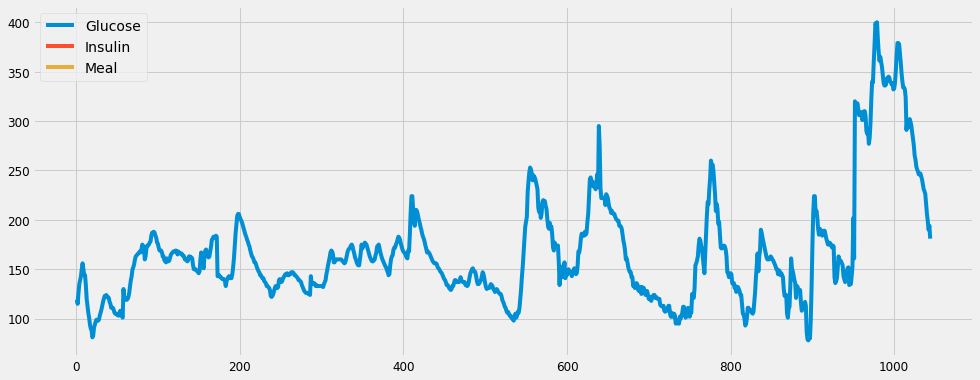

In [675]:
df.plot(figsize=(15,6))
plt.show()

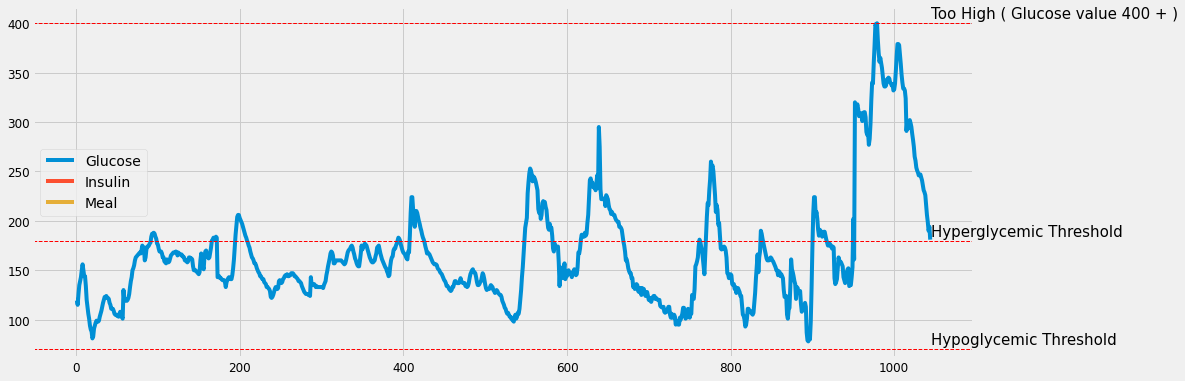

In [676]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [677]:
#df.drop(0,inplace=True)

In [678]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [679]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [680]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [681]:
#interpolate_glucose(df,'Glucose')

In [682]:
#meal

In [683]:
#insul

In [684]:
df['Glucose'].isnull().sum()

0

In [685]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [686]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [687]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [688]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

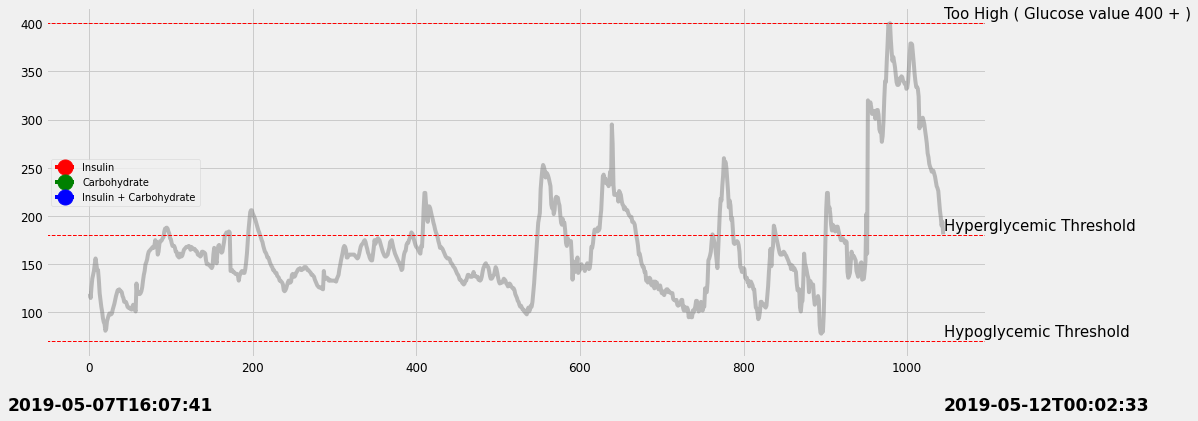

In [689]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [690]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [691]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [692]:
df[1900:1950]

Empty DataFrame
Columns: [Timestamp, Event, Glucose, Insulin, Meal]
Index: []

In [693]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [694]:
fix_glucose_value(df,'Glucose')

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [695]:
import numpy as np
import tensorflow as tf
import random as rn

In [696]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [697]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [698]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [699]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [700]:
leaky_relu = tf.nn.leaky_relu

## 15분

In [701]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [702]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

In [703]:
len(raw_seq) * 0.7

731.5

In [704]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [705]:
# SG필터 적용하는 부분 
# x_train_uni_origin 이런 식이었음 
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=2 # 이거 -1이면 naive method 
#x_train_uni,y_train_uni = uni_data(,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)

In [706]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [707]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [708]:
y_val_uni.shape

(306,)

In [709]:
y_train_uni.shape

(725,)

In [710]:
#y_train_uni_origin[:10]

In [711]:
#y_train_uni.shape

In [712]:
#x_train_uni[2]

In [713]:
#y_train_uni[2]

In [714]:
#df['Glucose'].head(10)

In [393]:
x_train_uni.shape[-2:]

(6, 1)

### RNN - 15분

In [715]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [716]:
from keras.layers import SimpleRNN

In [396]:
#n_steps = 3
#delay=3
#n_features=1

In [744]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)


In [745]:
K.set_session(sess)

In [746]:
model = Sequential()
model.add(SimpleRNN(50,activation=leaky_relu,input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [747]:
model.compile(optimizer='adam',loss='mse')

In [748]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [749]:
K.clear_session()

In [750]:
val_rnn_15_predict_result = model.predict(x_val_uni,verbose=0)

In [751]:
# 예측값 상한선 = 400 
for i in range(len(val_rnn_15_predict_result)):
    if val_rnn_15_predict_result[i] >= 400: 
        val_rnn_15_predict_result[i]=400

In [752]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,val_rnn_15_predict_result))
val_rnn_15 = RMSE(y_val_uni_origin,val_rnn_15_predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  25.244621034399255


#### Validation

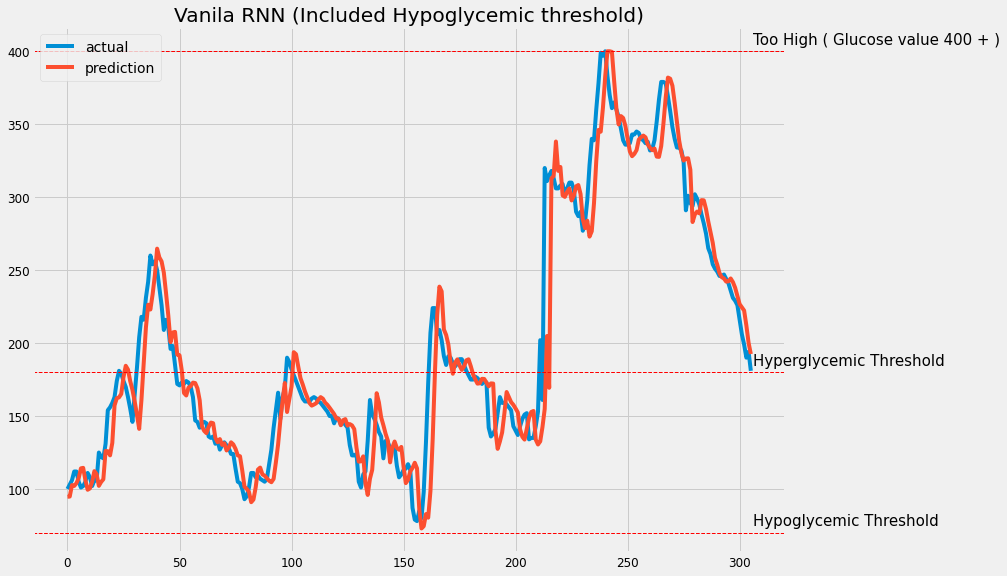

In [753]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [407]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

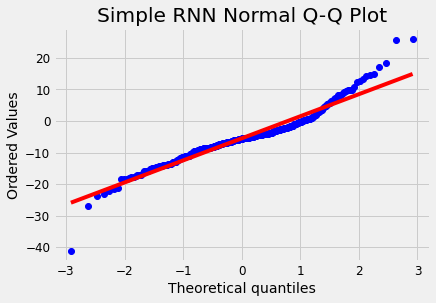

In [408]:
residuals = [y_val_uni_origin[i]-val_rnn_15_predict_result[i] for i in range(len(val_rnn_15_predict_result))]
residuals = y_val_uni_origin - val_rnn_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

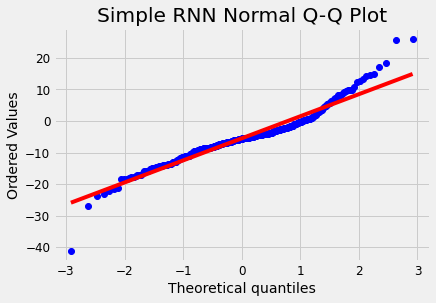

In [409]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [410]:
residuals=DataFrame(residuals)

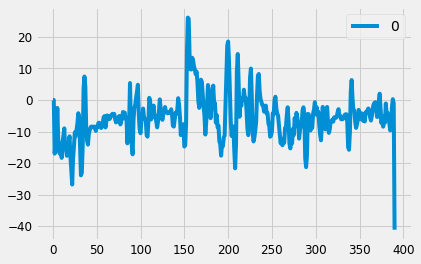

In [411]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac1665ec10>]],
      dtype=object)

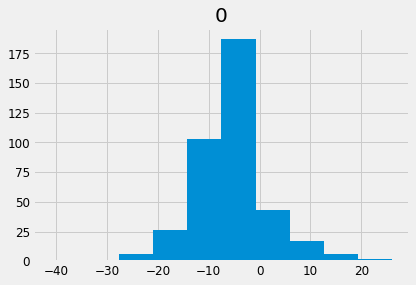

In [412]:

residuals.hist()

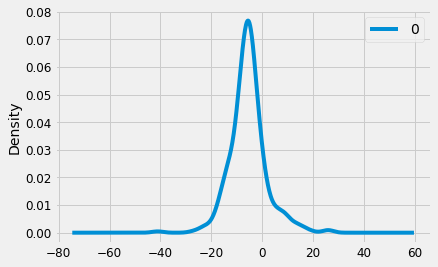

In [413]:
residuals.plot(kind='kde')

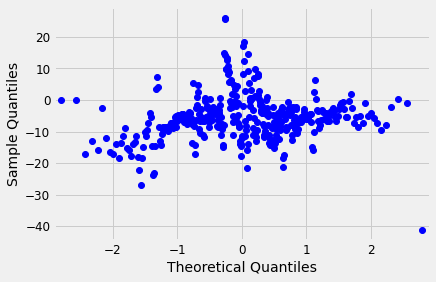

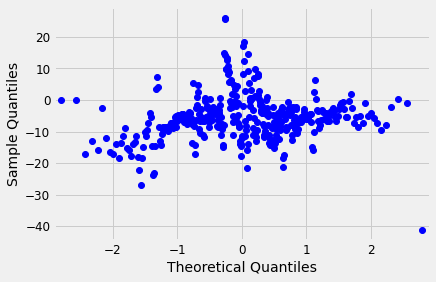

In [414]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [415]:
# 트레이닝셋 rmse 구하는 부분 
train_rnn_15_predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(train_rnn_15_predict_result)):
    if train_rnn_15_predict_result[i] >= 400: 
        train_rnn_15_predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,train_rnn_15_predict_result))
train_rnn_15=RMSE(y_train_uni_origin,train_rnn_15_predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  12.091659902979355


#### Train

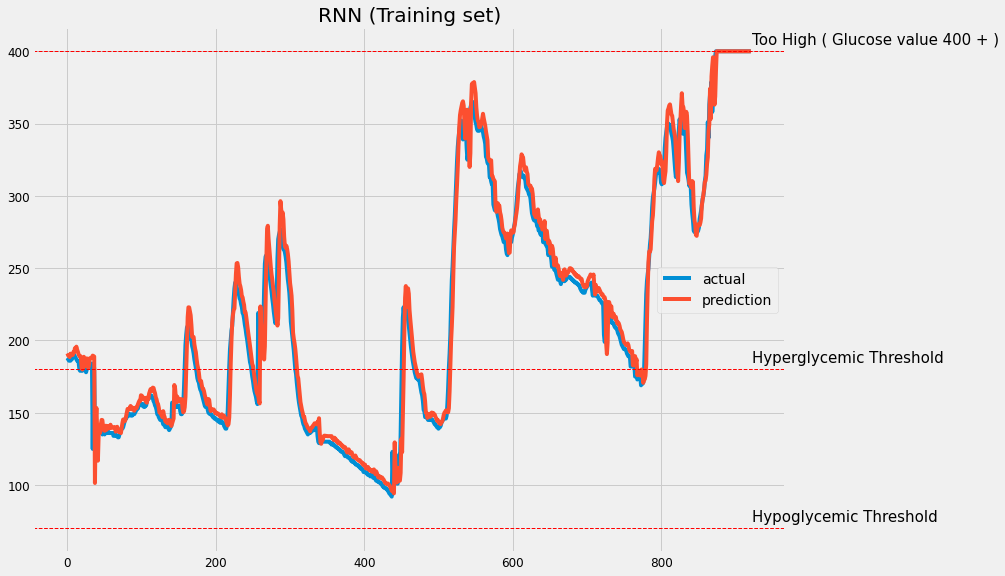

In [416]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

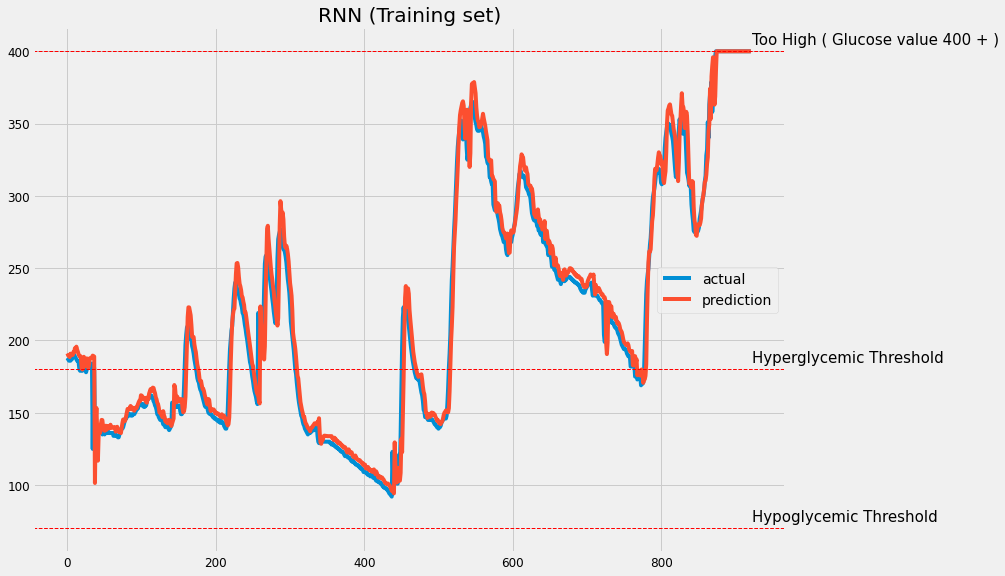

In [417]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [771]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [772]:
model = Sequential()
model.add(LSTM(50,activation=leaky_relu,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


In [773]:
model.compile(optimizer='adam',loss='mse')

In [774]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [775]:
K.clear_session()

In [776]:
val_lstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [777]:
# 예측값 상한선 = 400 
for i in range(len(val_lstm_15_predict_result)):
    if val_lstm_15_predict_result[i] >= 400: 
        val_lstm_15_predict_result[i]=400

In [425]:
#predict_result

In [778]:
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,val_lstm_15_predict_result))
val_lstm_15=RMSE(y_val_uni_origin,val_lstm_15_predict_result)

 LSTM - RMSE (15min) :  27.511836137722195


In [770]:
TRAIN_SPLIT

731

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

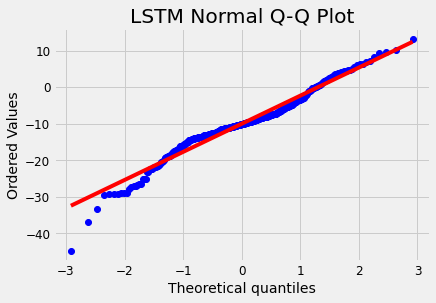

In [428]:
residuals = [y_val_uni_origin[i]-val_lstm_15_predict_result[i] for i in range(len(val_lstm_15_predict_result))]
residuals = y_val_uni_origin - val_lstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

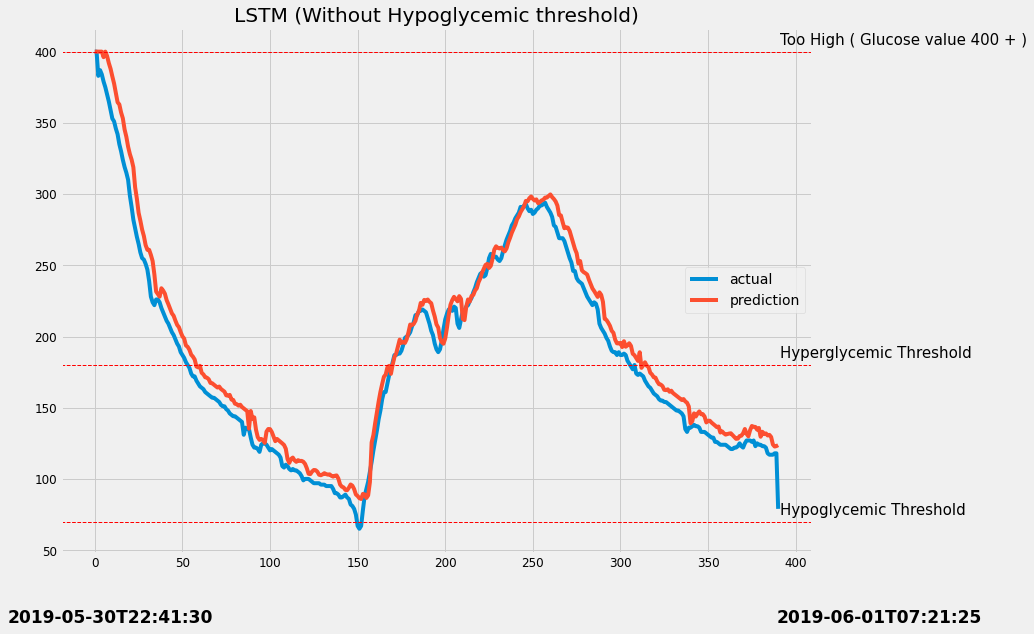

In [429]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [430]:
# 트레이닝셋 RMSE 계산 
train_lstm_15_predict_result = model.predict(x_train_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(train_lstm_15_predict_result)):
    if train_lstm_15_predict_result[i] >= 400: 
        train_lstm_15_predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_lstm_15_predict_result))
train_lstm_15 =RMSE(y_train_uni_origin,train_lstm_15_predict_result)

 LSTM - RMSE (15min) Training set :  13.66130007012883


#### Train

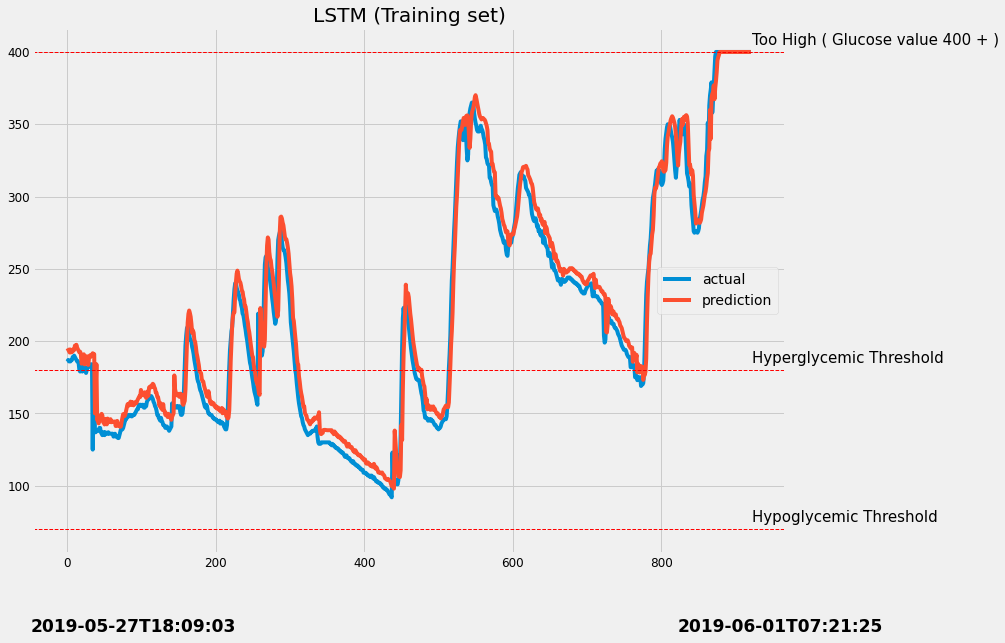

In [431]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_lstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

## RNN_15 & LSTM_15 GA

### TEST_Voting

In [432]:
test_GA = (val_rnn_15_predict_result + val_lstm_15_predict_result )/2

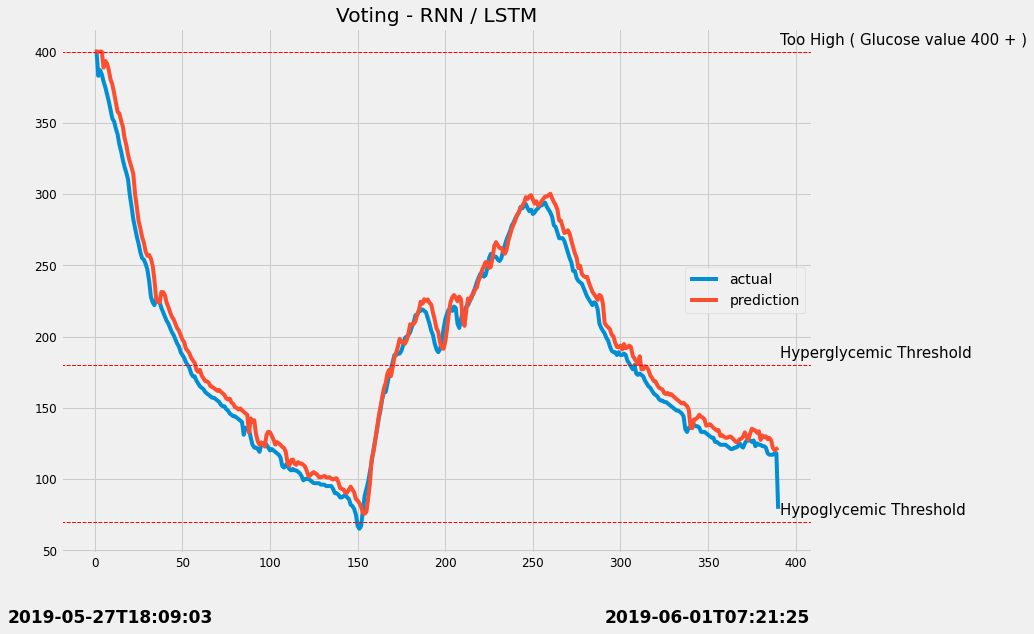

In [433]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(test_GA,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(test_GA),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(test_GA),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(test_GA),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Voting - RNN / LSTM',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(test_GA)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

In [434]:
test_rmse = RMSE(y_val_uni_origin,test_GA)
print(' voting - RNN / LSTM - RMSE  : ',test_rmse)

 voting - RNN / LSTM - RMSE  :  10.50706147958673


### Stacked LSTM - 15분

In [832]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [833]:
model = Sequential()
model.add(LSTM(50,activation='swish',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

ValueError: ignored

In [827]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [828]:
K.clear_session()

In [829]:
val_slstm_15_predict_result = model.predict(x_val_uni,verbose=0)


In [830]:
for i in range(len(val_slstm_15_predict_result)):
    if val_slstm_15_predict_result[i] >= 400: 
        val_slstm_15_predict_result[i]=400

In [831]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,val_slstm_15_predict_result))
val_stacklstm_15 =RMSE(y_val_uni_origin,val_slstm_15_predict_result)

 Stacked LSTM - RMSE(15min) :  26.0651092306197


#### Validation

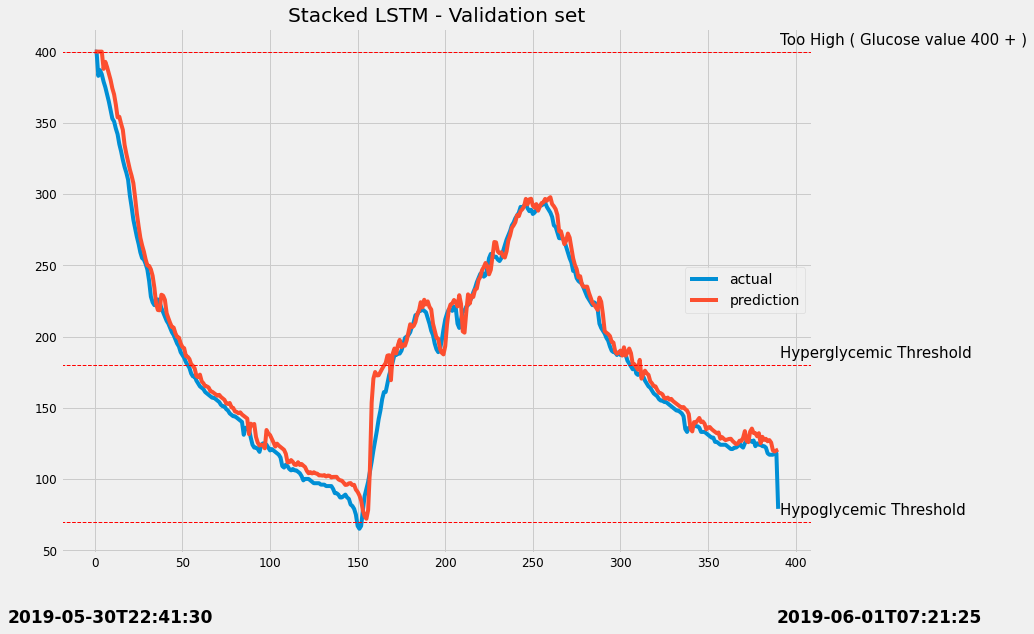

In [442]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_slstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_slstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_slstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

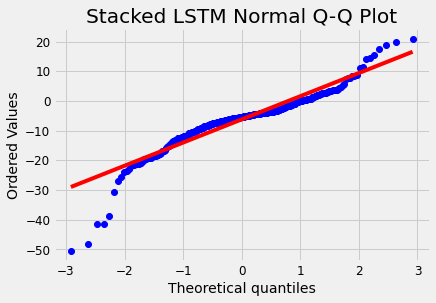

In [443]:
residuals = [y_val_uni[i]-val_slstm_15_predict_result[i] for i in range(len(val_slstm_15_predict_result))]
residuals = y_val_uni - val_slstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [444]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  11.192644280412281


#### Train

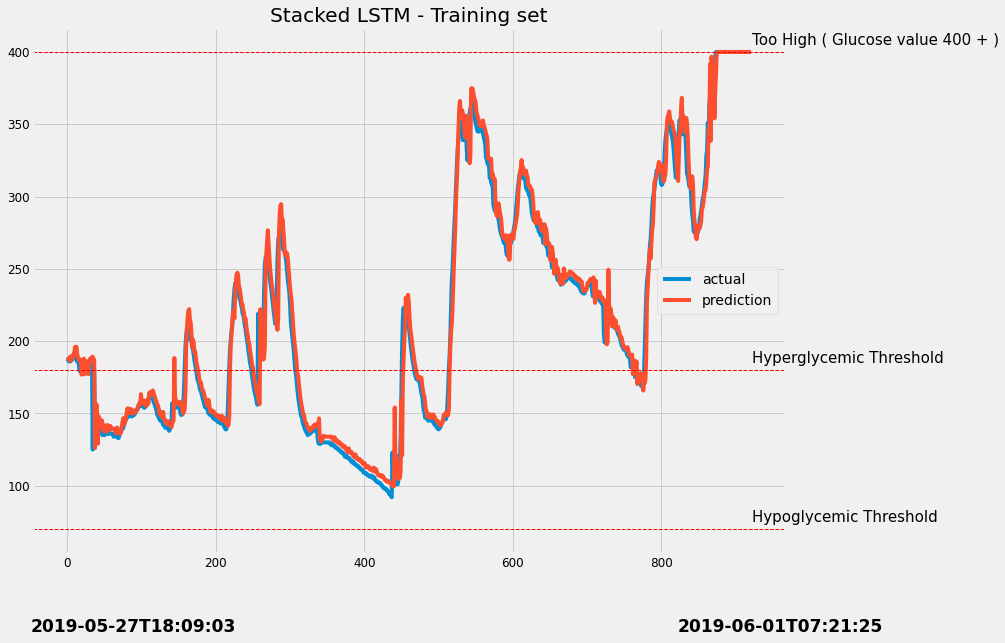

In [445]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [855]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [857]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [850]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

RuntimeError: ignored

In [844]:
K.clear_session()

In [845]:
val_bilstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [846]:
for i in range(len(val_bilstm_15_predict_result)):
    if val_bilstm_15_predict_result[i] >= 400: 
        val_bilstm_15_predict_result[i]=400

In [847]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,val_bilstm_15_predict_result))
val_bilstm_15 = RMSE(y_val_uni_origin,val_bilstm_15_predict_result)

Bidirectional LSTM - RMSE :  27.059228486210344


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

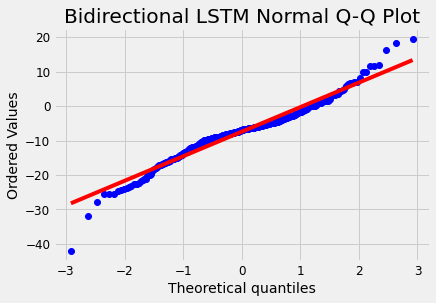

In [453]:
residuals = [y_val_uni[i]-val_bilstm_15_predict_result[i] for i in range(len(val_bilstm_15_predict_result))]
residuals = y_val_uni - val_bilstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

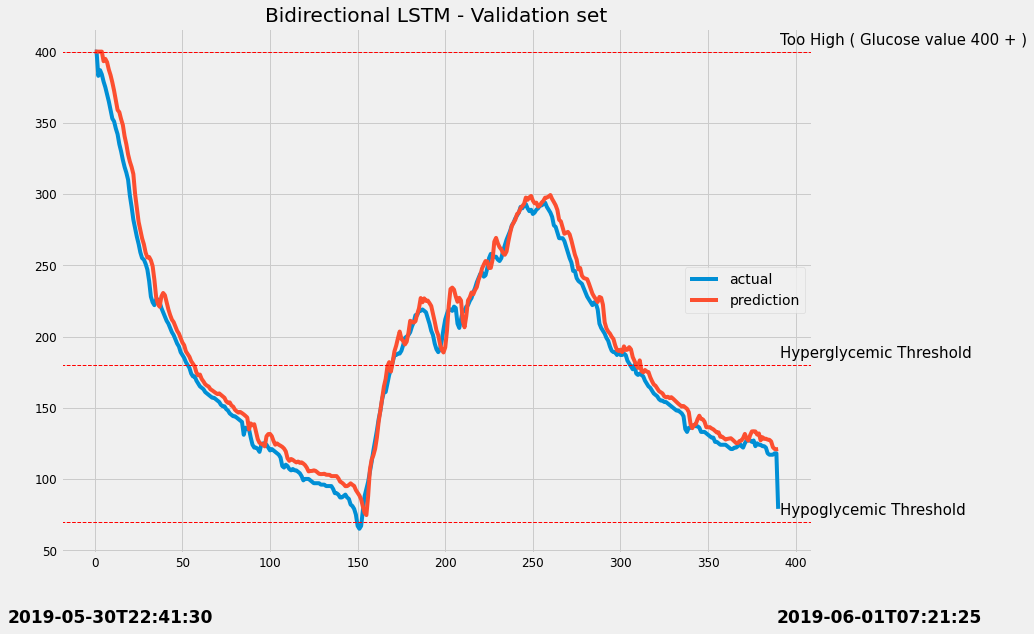

In [454]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_bilstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_bilstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_bilstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_bilstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [455]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  12.517502864514466


#### Train

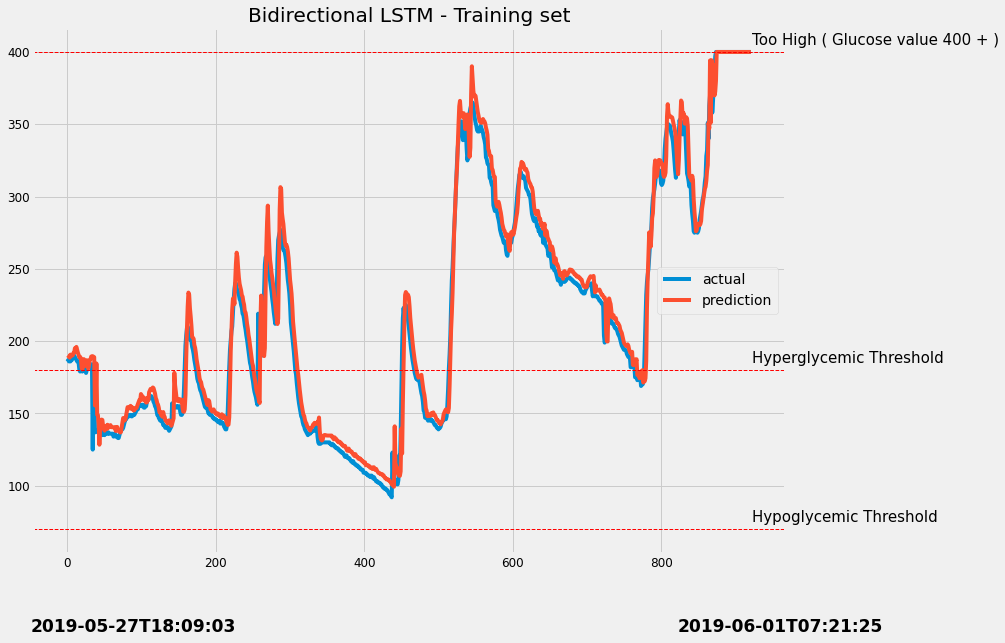

In [456]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [858]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [859]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [860]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [861]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [862]:
K.clear_session()

In [863]:
val_gru_15_predict_result = model.predict(x_val_uni,verbose=0)

In [864]:
for i in range(len(val_gru_15_predict_result)):
    if val_gru_15_predict_result[i] >= 400: 
        val_gru_15_predict_result[i]=400

In [464]:
#predict_result

In [465]:
#predict_result

In [865]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,val_gru_15_predict_result))
val_gru_15 = RMSE(y_val_uni_origin,val_gru_15_predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  25.339848713168017


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

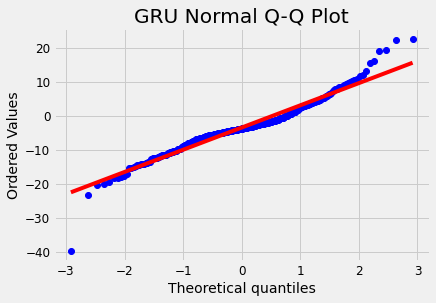

In [467]:
residuals = [y_val_uni[i]-val_gru_15_predict_result[i] for i in range(len(val_gru_15_predict_result))]
residuals = y_val_uni - val_gru_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

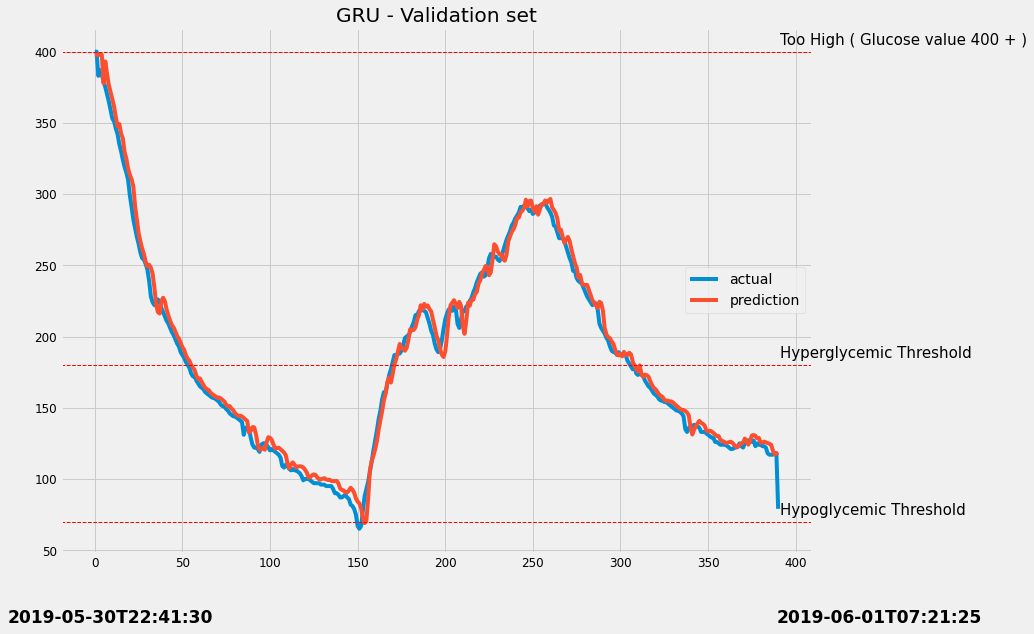

In [468]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_gru_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_gru_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_gru_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_gru_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [469]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_15 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  11.333115533670234


#### Train

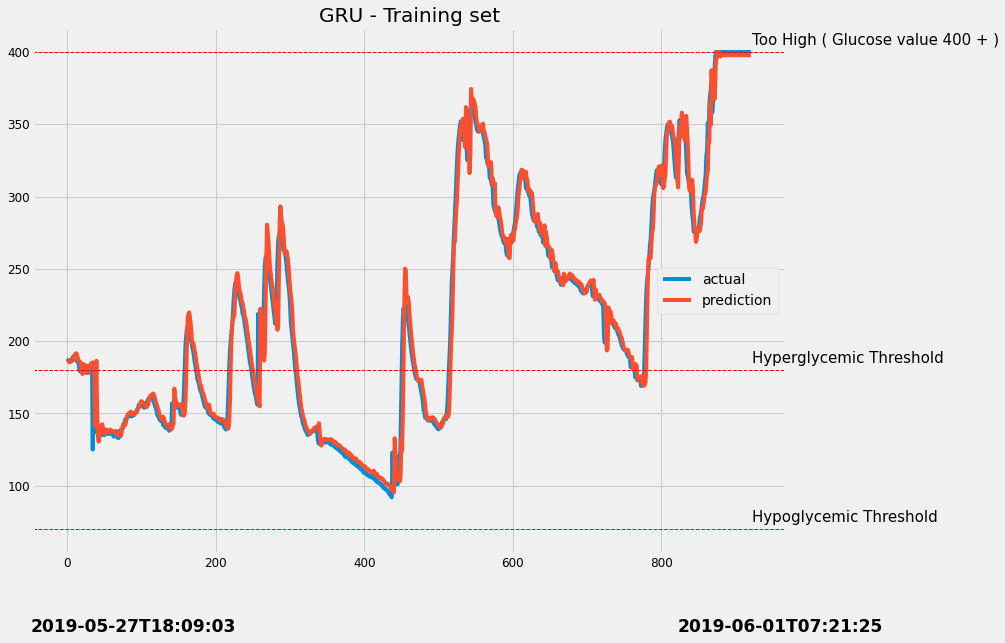

In [470]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [471]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [472]:
#residuals.plot(kind='kde')

In [473]:
#residuals.plot()

In [474]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

### Genetic Algorithm - 15Min

In [475]:
pip install geneticalgorithm2

In [476]:
import numpy as np
from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

In [477]:
val_rnn_15 = round(val_rnn_15,2)
val_lstm_15 = round(val_lstm_15,2)
val_stacklstm_15 = round(val_stacklstm_15,2)
val_bilstm_15 = round(val_bilstm_15,2)
val_gru_15 = round(val_gru_15,2)


In [478]:
#val_rnn_15_predict_result[:5]

In [479]:
ex = val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2

In [480]:
#ex = val_rnn_15_predict_result * 0.3 + val_lstm_15_predict_result * 0.1 + val_slstm_15_predict_result * 0.14 + val_bilstm_15_predict_result * 0.11 + val_gru_15_predict_result * 0.35

In [481]:
# Baseline
test_result = RMSE(y_val_uni_origin,ex)
test_result

9.399667661047408

In [482]:
#test_result = 200 - RMSE(y_val_uni_origin,ex)
test_result = 200 - RMSE(val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2,ex)


In [483]:
val_rnn_15_predict_result = np.asarray(val_rnn_15_predict_result)
val_lstm_15_predict_result = np.asarray(val_lstm_15_predict_result)
val_slstm_15_predict_result = np.asarray(val_slstm_15_predict_result)
val_bilstm_15_predict_result = np.asarray(val_bilstm_15_predict_result)
val_gru_15_predict_result = np.asarray(val_gru_15_predict_result)

In [484]:
#def cal()
#from sklearn.metrics import mean_squared_error
#def RMSE(y_test,y_predict):
#    return np.sqrt(mean_squared_error(y_test,y_predict))

In [485]:
def evaluate(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  result =[]
  #print(X)
  if sum(X) > 9900 and sum(X) < 10000:
    print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    result = (val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
                 val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
                 val_gru_15_predict_result * (X[4] / 10000))

    pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print(pen)
    print("\n ** C ** \n")
    print(pen)
  #return np.sum(X) + pen
    #count += 1 
  return result - pen
    
    

In [486]:
def evaluate2(X):
  pen = 0 
  coef = []
  
  #print(X)
  if sum(X) >  0.98 and sum(X) < 1:
    print("A \n")
    print(X)
    # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    result = (val_rnn_15_predict_result * X[0] + val_lstm_15_predict_result * X[1] +
                 val_slstm_15_predict_result * X[2] + val_bilstm_15_predict_result * X[3] +
                 val_gru_15_predict_result * X[4])
    pen = RMSE(y_val_uni_origin,result)
  
    print("C \n")
    print(pen - test_result)
  return pen - test_result
    
    

In [487]:
varbound = np.array([[500,5000]]*5)

In [488]:
varbound2 = np.array([[0.1,0.5]]*5)

In [489]:
algorithm_param = {'max_num_iteration': 10000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [490]:
#model.clear_session()

In [491]:
#model = ga(function = evaluate, dimension = 5, variable_type='int',variable_boundaries=varbound,algorithm_parameters = algorithm_param)

In [492]:
#model2 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

In [493]:
#model.run()

## 30분

In [494]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [495]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=5
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [496]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [497]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [498]:
x_train_uni.shape


(922, 6, 1)

In [499]:

x_val_uni.shape

(388, 6, 1)

In [500]:
x_train_uni[0]

array([[199],
       [199],
       [194],
       [193],
       [190],
       [189]])

In [501]:
df['Glucose'].head(15)

0     199
1     199
2     194
3     193
4     190
5     189
6     188
7     187
8     186
9     187
10    186
11    186
12    186
13    187
14    187
Name: Glucose, dtype: object

In [502]:
y_train_uni[0]

186

### RNN - 30분

In [503]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [504]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [505]:
model.compile(optimizer='adam',loss='mse')

In [506]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [507]:
val_rnn_30_predict_result = model.predict(x_val_uni,verbose=0)

In [508]:
K.clear_session()

In [509]:
predict_result = model.predict(x_val_uni,verbose=0)

In [510]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
# GA에 사용 
val_rnn_30_predict_result = predict_result

In [511]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_30 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  14.32844377623908


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

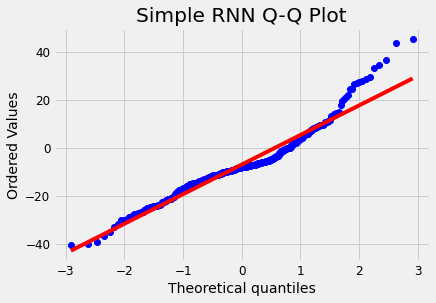

In [512]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

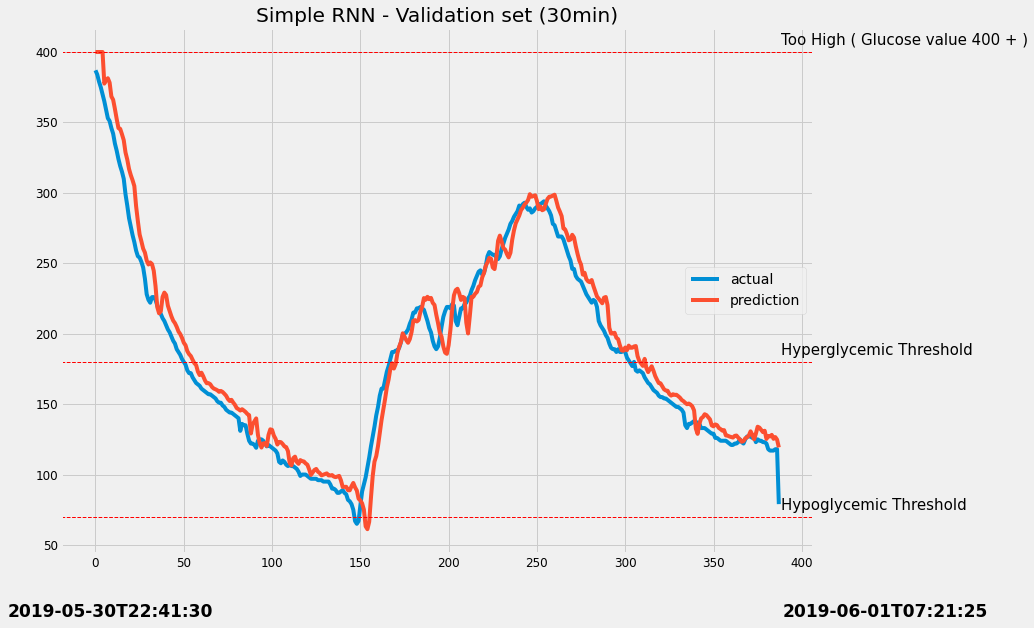

In [513]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

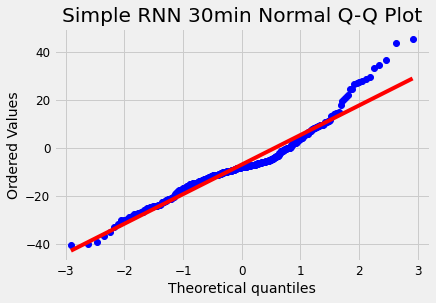

In [514]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [515]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_30=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  19.856947972028046


#### Train

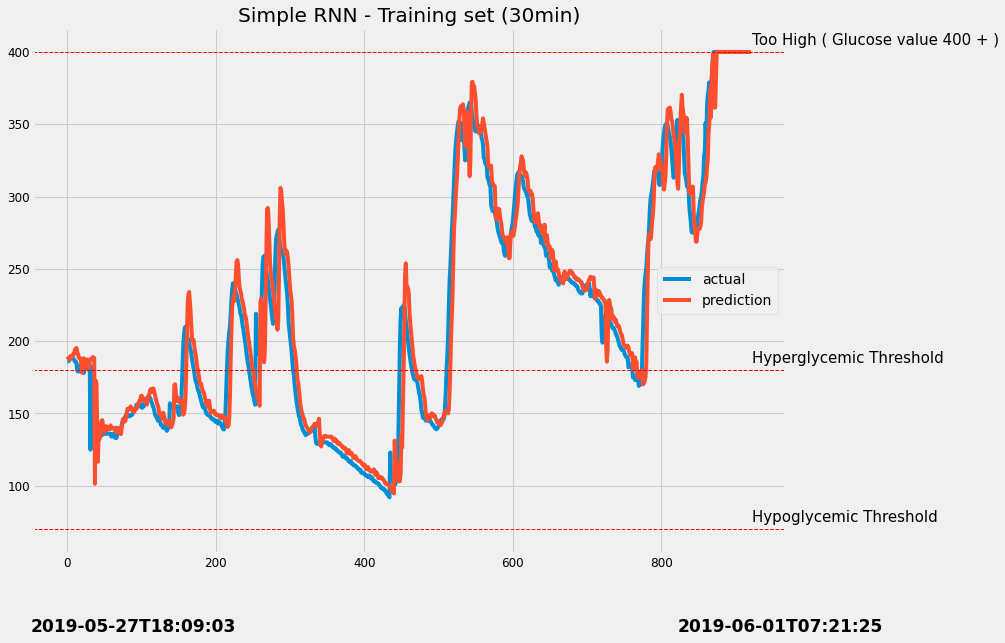

In [516]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [517]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [518]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


In [519]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)
val_lstm_30_predict_result = model.predict(x_val_uni,verbose=0)
K.clear_session()

In [520]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_30=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  20.141190909509998


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

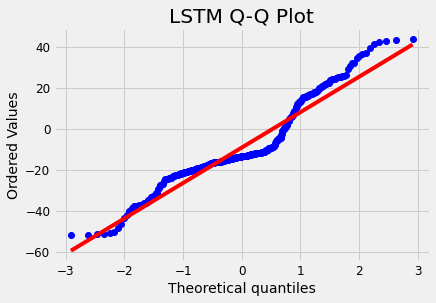

In [521]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

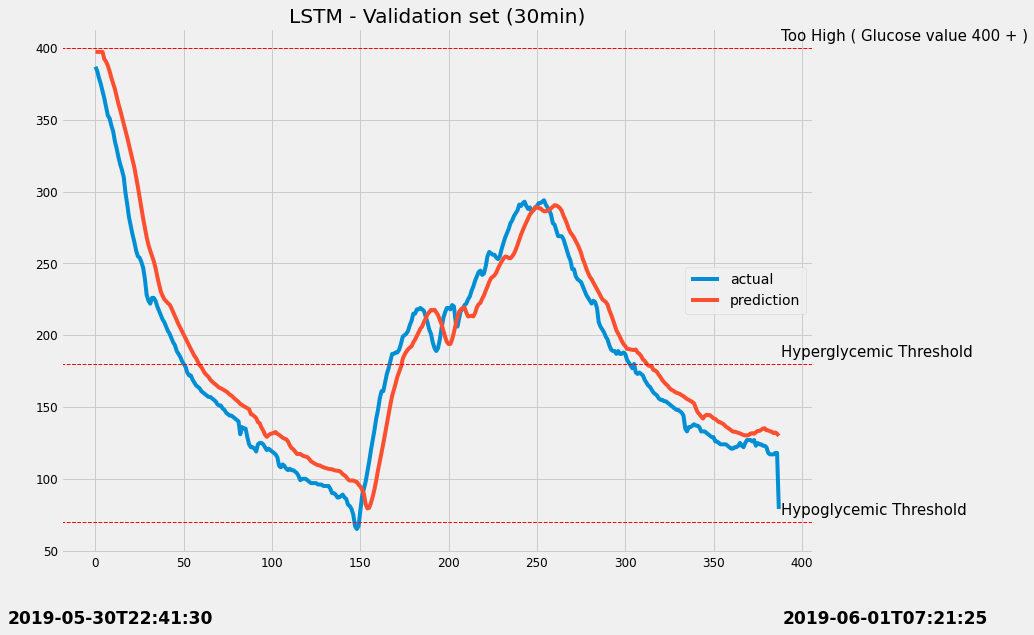

In [522]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [523]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_30 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  24.856680413076006


#### Train

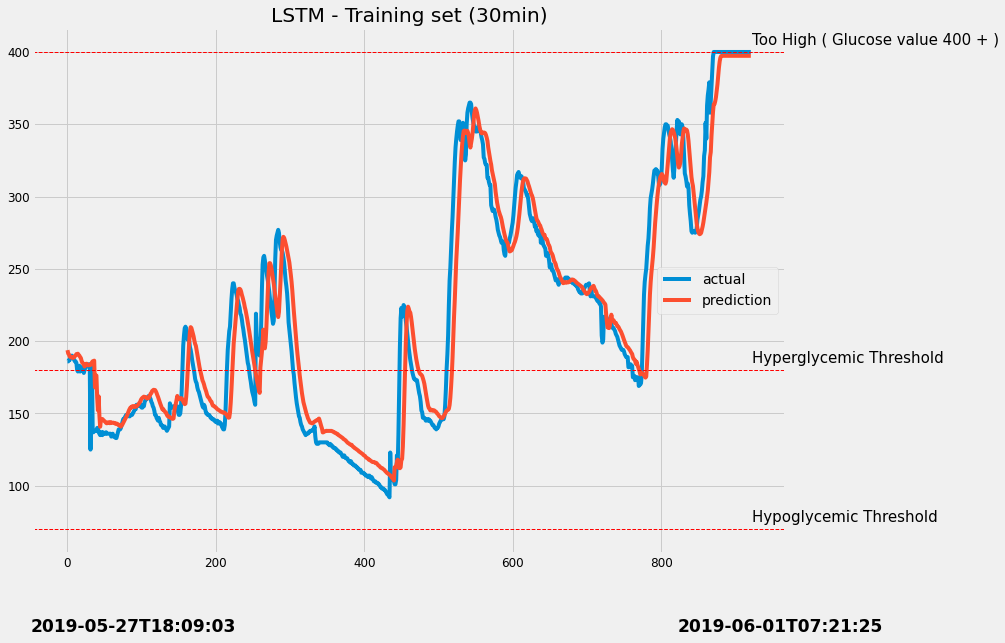

In [524]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [525]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [526]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [527]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [528]:
K.clear_session()

In [529]:
val_slstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [530]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_30 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  17.880351996020366


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

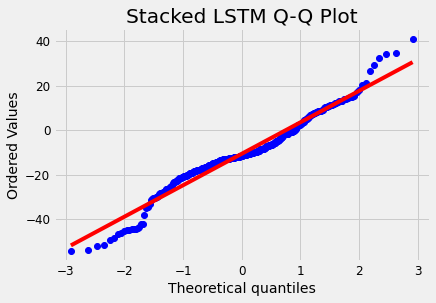

In [531]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

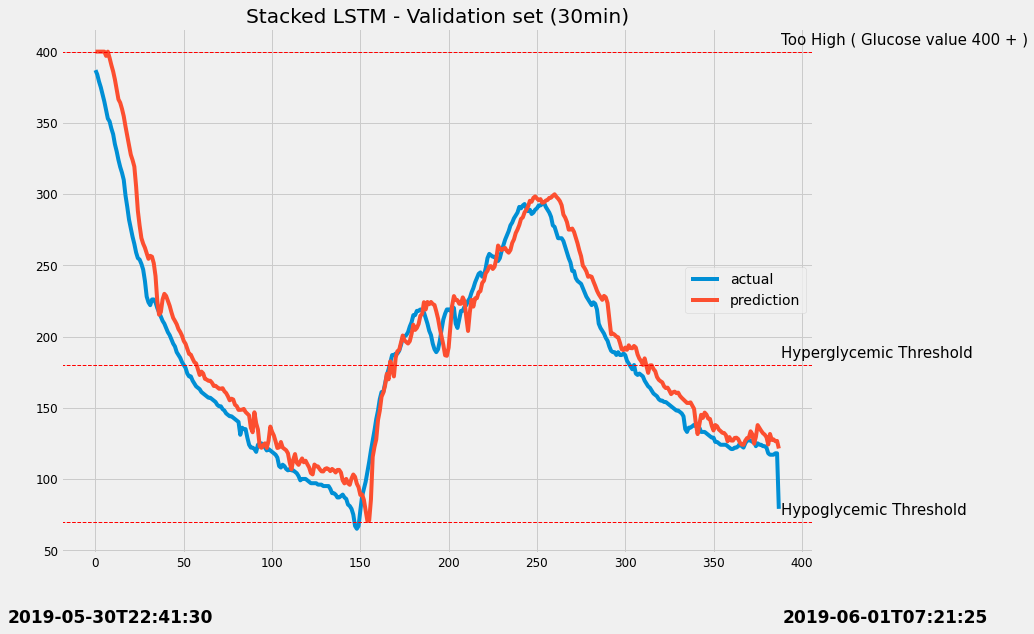

In [532]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [533]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  20.29903288619506


#### Train

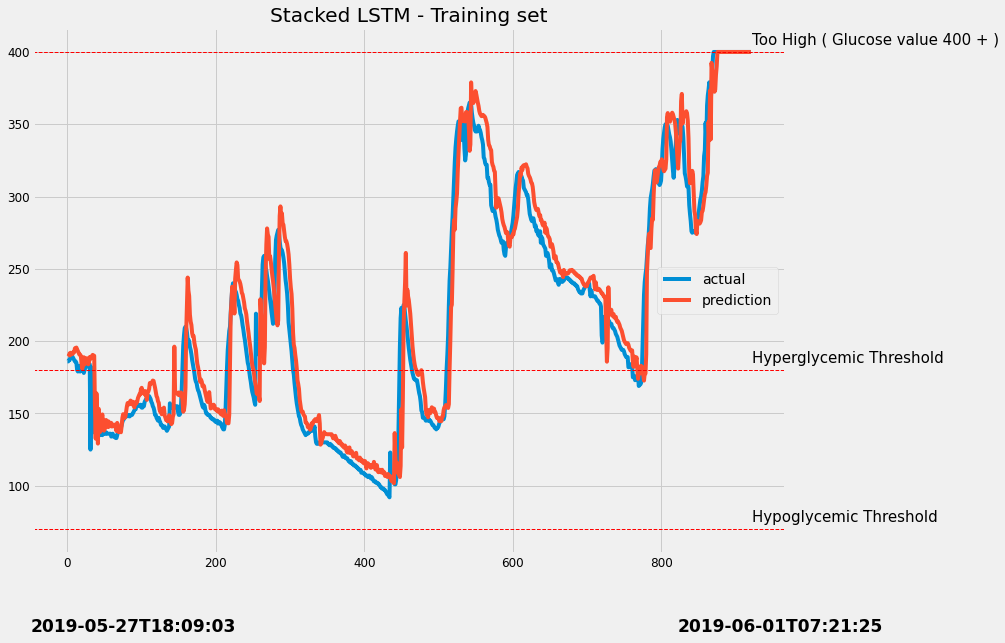

In [534]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [535]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [536]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [537]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [538]:
val_bilstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [539]:
K.clear_session()

In [540]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_30 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  23.192335428863455


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

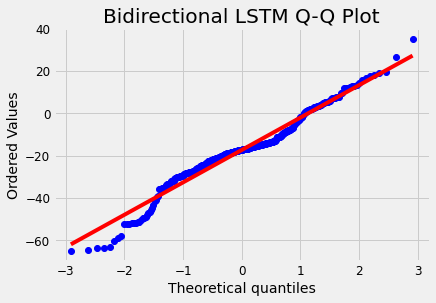

In [541]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

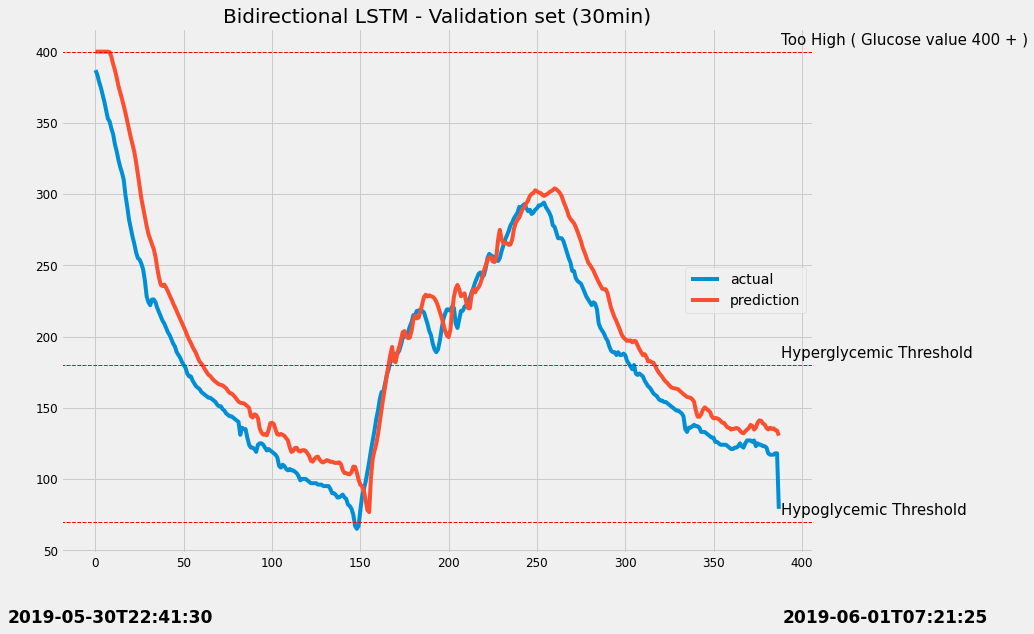

In [542]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [543]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  23.969467379478843


#### Train

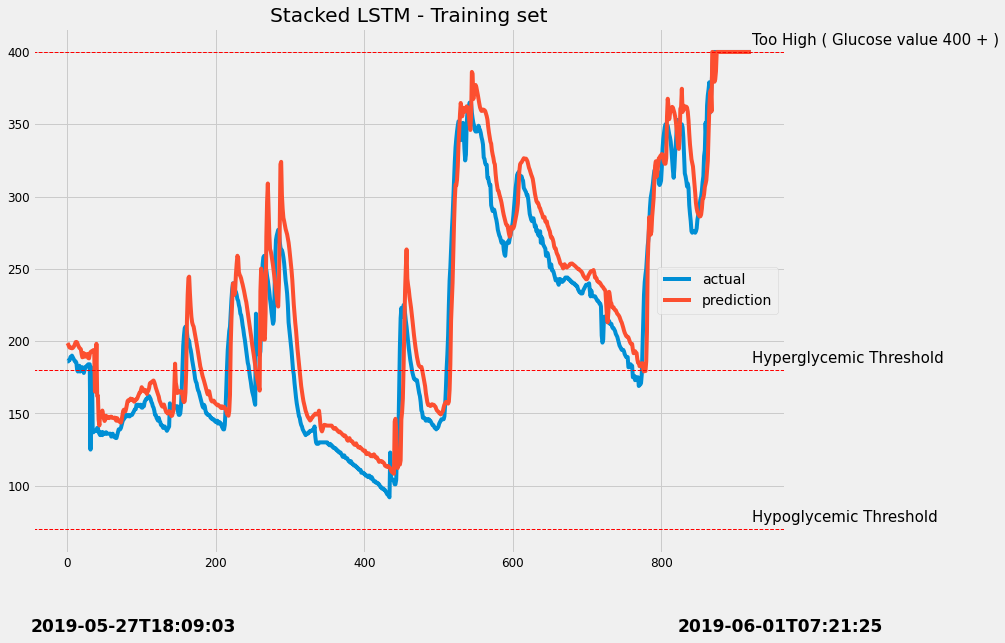

In [544]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [545]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [546]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [547]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()
val_gru_30_predict_result = model.predict(x_val_uni,verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [548]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  15.097504446704837


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

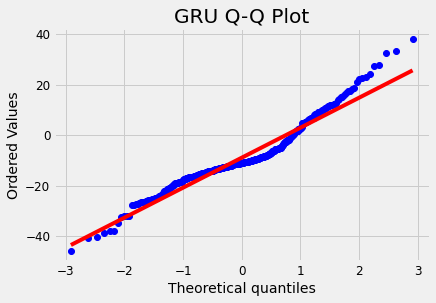

In [549]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

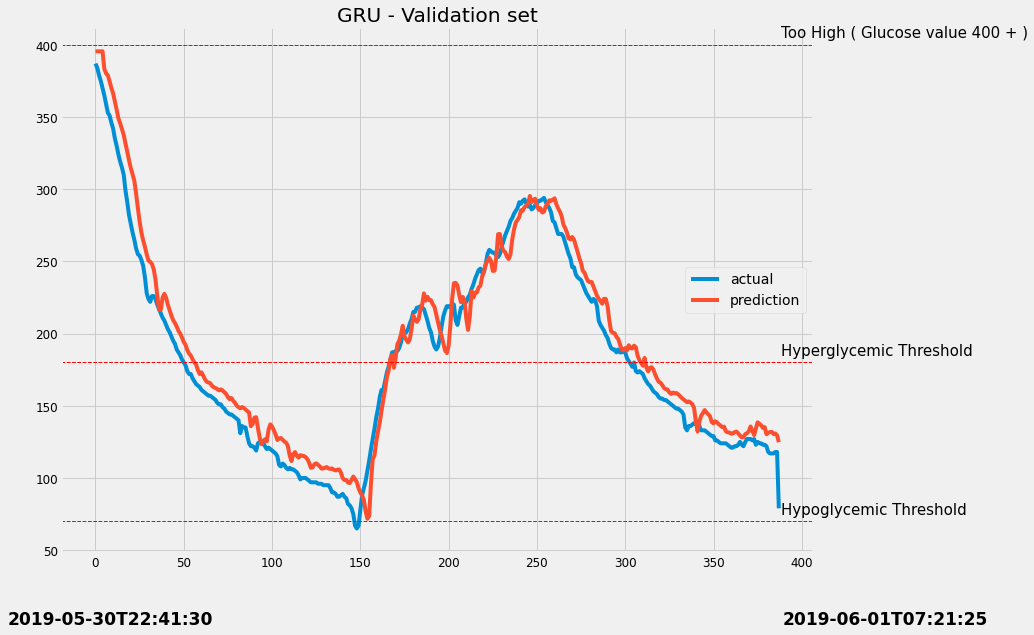

In [550]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [551]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_30 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  19.544154997300467


#### Train

### GA

In [552]:
ex = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 + val_gru_30_predict_result * 0.2

In [566]:
ex2 = val_rnn_30_predict_result * 0.43578443     + val_lstm_30_predict_result *  0.07653674+ val_slstm_30_predict_result *  0.07391771 + val_bilstm_30_predict_result * 0.05667096+ val_gru_30_predict_result *0.34709233

In [567]:
#test_result =  RMSE(y_val_uni_origin,ex2)
#test_result

14.344851371118093

In [571]:
test_result =  mean_squared_error(y_val_uni_origin,ex)
test_result

311.520077190932

In [428]:
test_result * 2 - (1000 + test_result)

580.4705363801818

In [ ]:
result = (test_result*2) - (1000 + mean_squared_error(y_val_uni_origin,abc))

In [378]:
mean_squared_error

<function sklearn.metrics._regression.mean_squared_error>

In [554]:
val_rnn_30_predict_result = np.asarray(val_rnn_30_predict_result)
val_lstm_30_predict_result = np.asarray(val_lstm_30_predict_result)
val_slstm_30_predict_result = np.asarray(val_slstm_30_predict_result)
val_bilstm_30_predict_result = np.asarray(val_bilstm_30_predict_result)
val_gru_30_predict_result = np.asarray(val_gru_30_predict_result)

In [269]:
def evaluate(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  result =[]
  #print(X)
  if sum(X) > 9900 and sum(X) < 10000:
    print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    result = (val_rnn_30_predict_result * (X[0] / 10000) + val_lstm_30_predict_result * (X[1] / 10000) +
                 val_slstm_30_predict_result * (X[2] / 10000) + val_bilstm_30_predict_result * (X[3] / 10000) +
                 val_gru_30_predict_result * (X[4] / 10000))

    pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print(pen)
    print("\n ** C ** \n")
    print(pen)
  #return np.sum(X) + pen
    #count += 1 
  return pen
    
    

(303,)

(303, 1)

In [572]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
    abc = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
    result = (test_result*2) - ((test_result/2) + mean_squared_error(y_val_uni_origin,abc))
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [573]:
abc = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 +val_gru_30_predict_result * 0.2
              

In [398]:
get = mean_squared_error(y_val_uni_origin,abc)

In [557]:
test_result*2 - mean_squared_error(y_val_uni_origin,abc)

311.520077190932

In [558]:
varbound = np.array([[500,5000]]*5)

In [559]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [602]:
algorithm_param = {'max_num_iteration': 40000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [272]:
model = ga(function = evaluate, dimension = 5, variable_type='int',variable_boundaries=varbound,algorithm_parameters = algorithm_param)

In [603]:
model2 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
267.61623887672255

 ** Count ** 

 ** B ** 

[0.49574565 0.05122316 0.05739768 0.05118687 0.33445831]

 ** C ** 

267.61623887672255

 ** Count ** 

 ** B ** 

[0.49574565 0.05122316 0.05739768 0.05118687 0.33445831]

 ** C ** 

267.61623887672255

 ** Count ** 

 ** B ** 

[0.49574565 0.05122316 0.05739768 0.05118687 0.33445831]

 ** C ** 

267.61623887672255

 ** Count ** 

 ** B ** 

[0.49574565 0.05122316 0.05739768 0.05118687 0.33445831]

 ** C ** 

267.61623887672255

 ** Count ** 

 ** B ** 

[0.49574565 0.05122316 0.05739768 0.05118687 0.33445831]

 ** C ** 

267.61623887672255

 ** Count ** 

 ** B ** 

[0.49574565 0.05122316 0.05739768 0.05118687 0.33445831]

 ** C ** 

267.61623887672255

 ** Count ** 

 ** B ** 

[0.49574565 0.05122316 0.05739768 0.05118687 0.33445831]

 ** C ** 

267.61623887672255

 ** Count ** 

 ** B ** 

[0.49574565 0.05122316 0.05739768 0.05118687 0.33445831]

 ** C ** 

267.61623887672255

 ** Count ** 

 ** B ** 

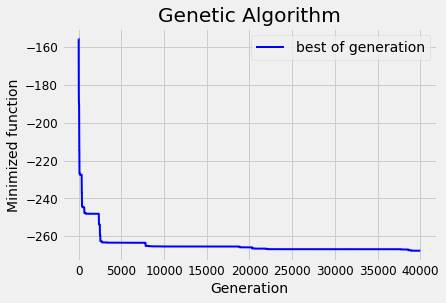

In [604]:
model2.run()

In [605]:
# RMSE 
optimized = val_rnn_30_predict_result * model2.output_dict['variable'][0] + val_lstm_30_predict_result *model2.output_dict['variable'][1] + val_slstm_30_predict_result * model2.output_dict['variable'][2] + val_bilstm_30_predict_result * model2.output_dict['variable'][3] + val_gru_30_predict_result * model2.output_dict['variable'][4]
optimized_rmse =  RMSE(y_val_uni_origin,optimized)
optimized_rmse

14.130246880705073

In [577]:
model2.output_dict

{'function': -266.90362017923087,
 'last_generation': {'scores': array([-266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90362018, -266.90362018,
         -266.90362018, -266.90362018, -266.90269143, -266.90269143,
         -266.90269143, -266.90269143, -266.90269143, -266.89773413,
         -266.89070381, -266.89070381, -266.89070381, -266.89070381,
         -266.89070381, -266.89070381, -

In [583]:
model2.output_dict['variable'][0]


0.4890091254057987

In [ ]:
def evaluate2(X):
  pen = 0 
  coef = []
  
  #print(X)
  if sum(X) >  0.98 and sum(X) < 1:
    print("A \n")
    print(X)
    # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    result = (val_rnn_15_predict_result * X[0] + val_lstm_15_predict_result * X[1] +
                 val_slstm_15_predict_result * X[2] + val_bilstm_15_predict_result * X[3] +
                 val_gru_15_predict_result * X[4])
    pen = 50 - RMSE(y_val_uni_origin,result)
  
    print("C \n")
    print(pen)
  return -pen
    
    

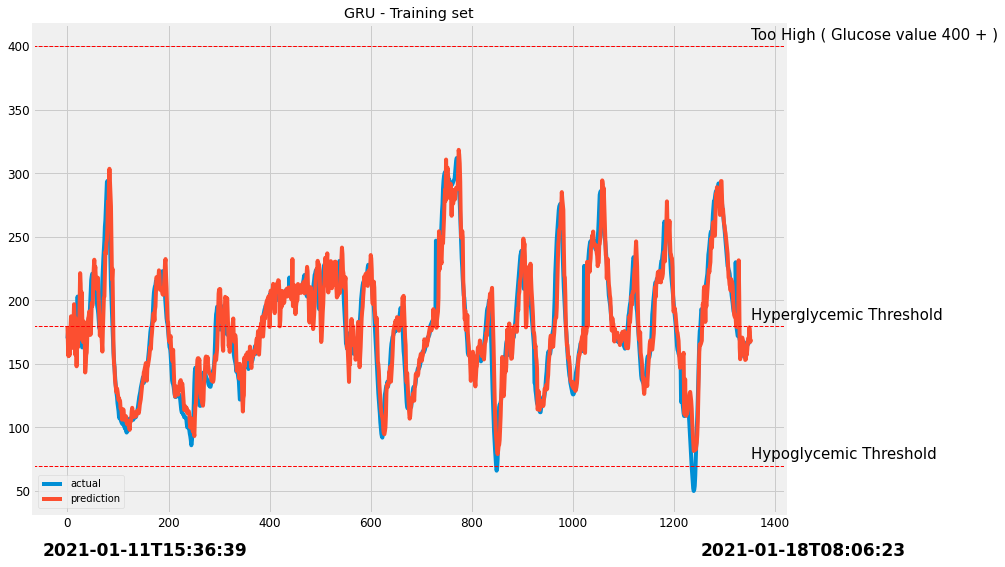

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [ ]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [ ]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=11
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [ ]:
x_train_uni[0]

array([[204],
       [177],
       [181],
       [181],
       [180],
       [181]])

In [ ]:
y_train_uni[0]

174

In [ ]:
df['Glucose'].head(20)

0     204.0
1     177.0
2     181.0
3     181.0
4     180.0
5     181.0
6     174.0
7     170.0
8     169.0
9     165.0
10    167.0
11    170.0
12    175.0
13    168.0
14    171.0
15    170.0
16    171.0
17    174.0
18    181.0
19    182.0
Name: Glucose, dtype: float64

### RNN - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_60 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  37.6520974374573


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

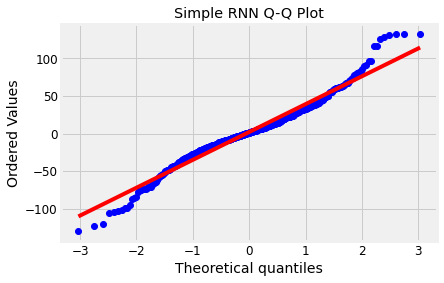

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

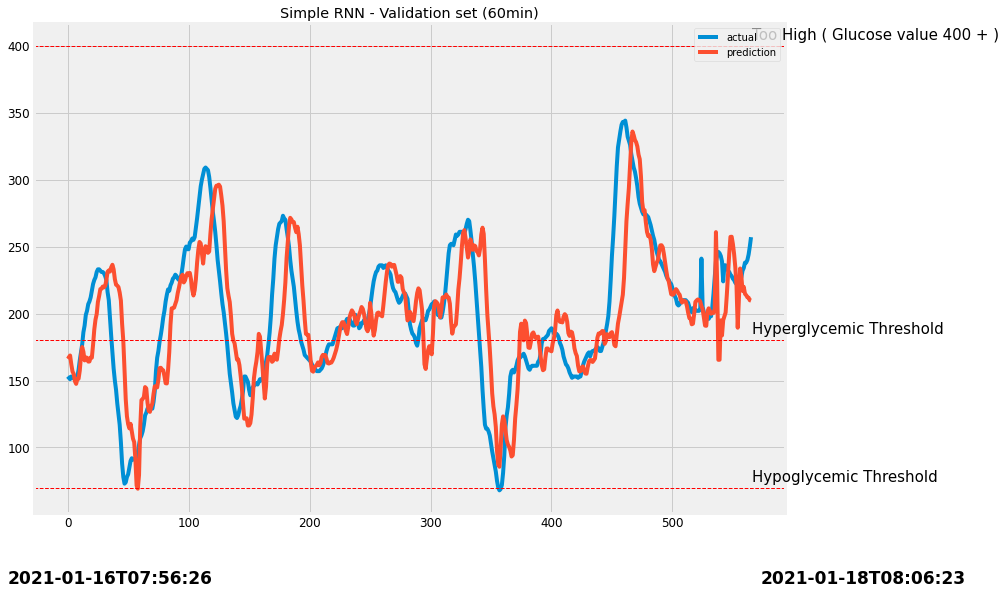

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

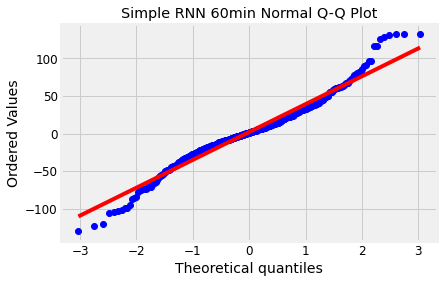

In [ ]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [ ]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_60=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  32.07400786281994


#### Train

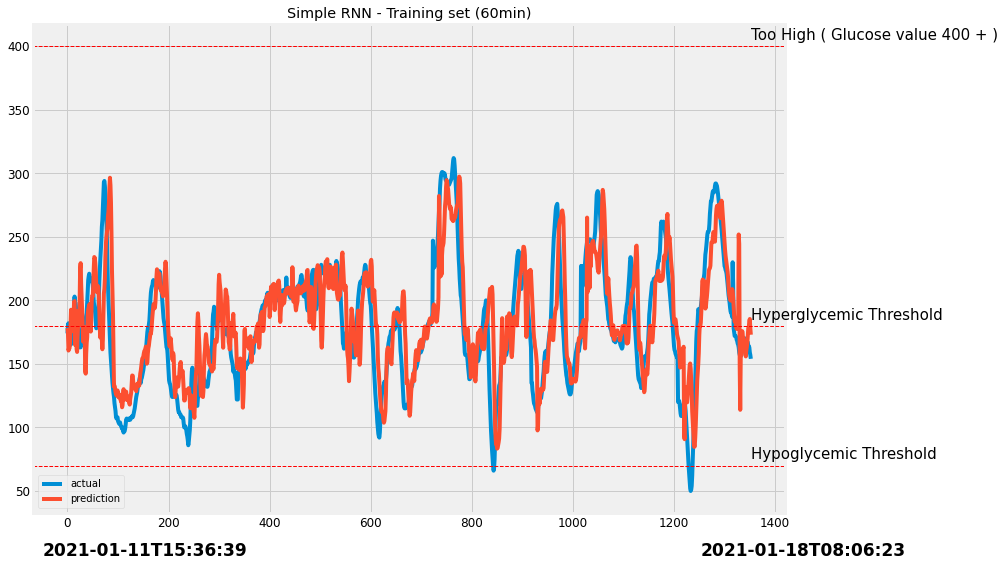

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_60=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (60min) :  37.03666706718292


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

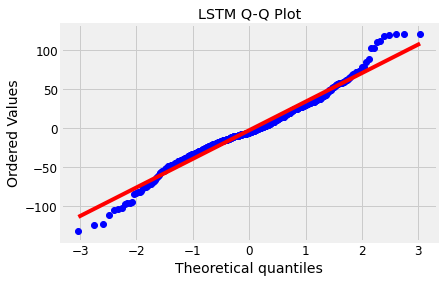

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

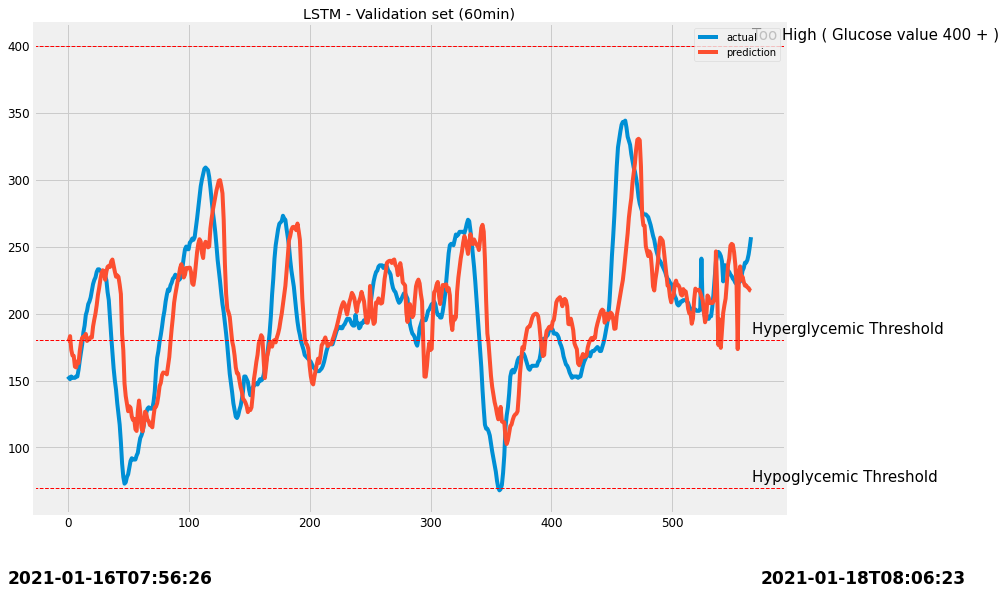

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_60 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (60min) Training set :  31.509319358418214


#### Train

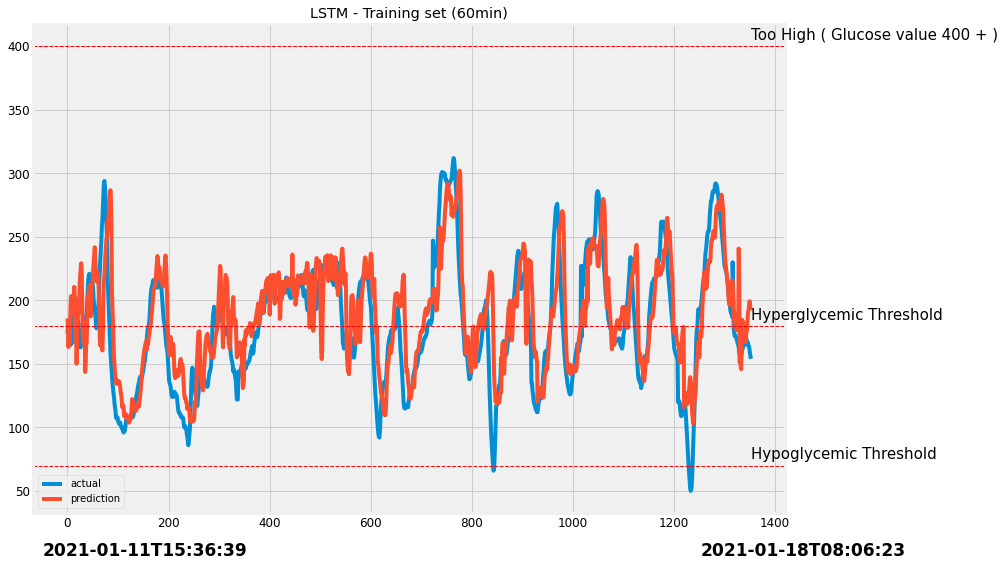

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_60 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  38.39375720069384


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

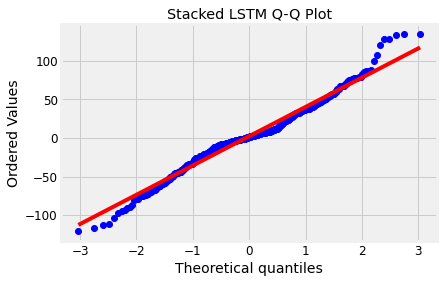

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

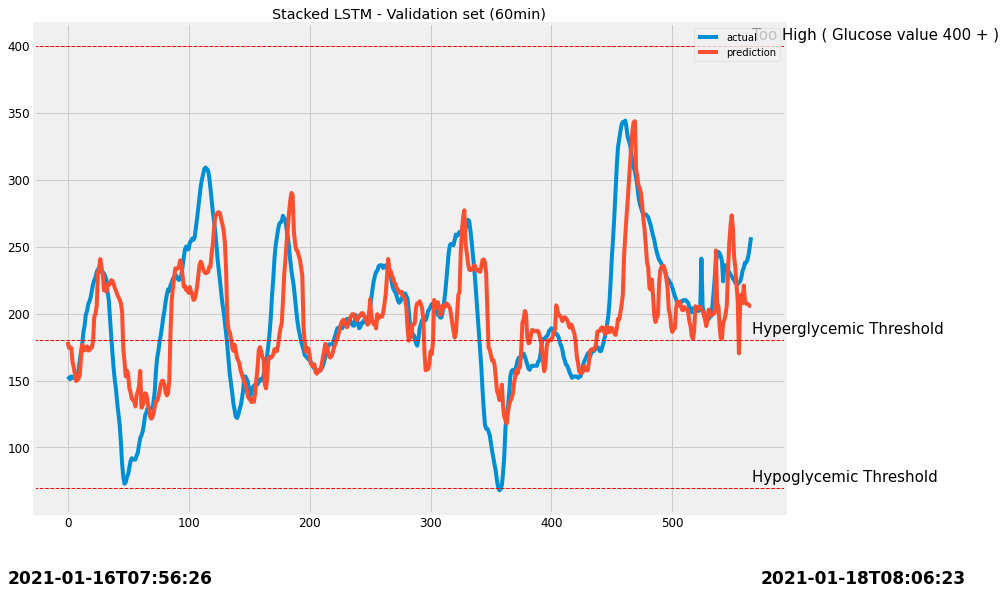

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (60min) Training set :  32.56755650448606


#### Train

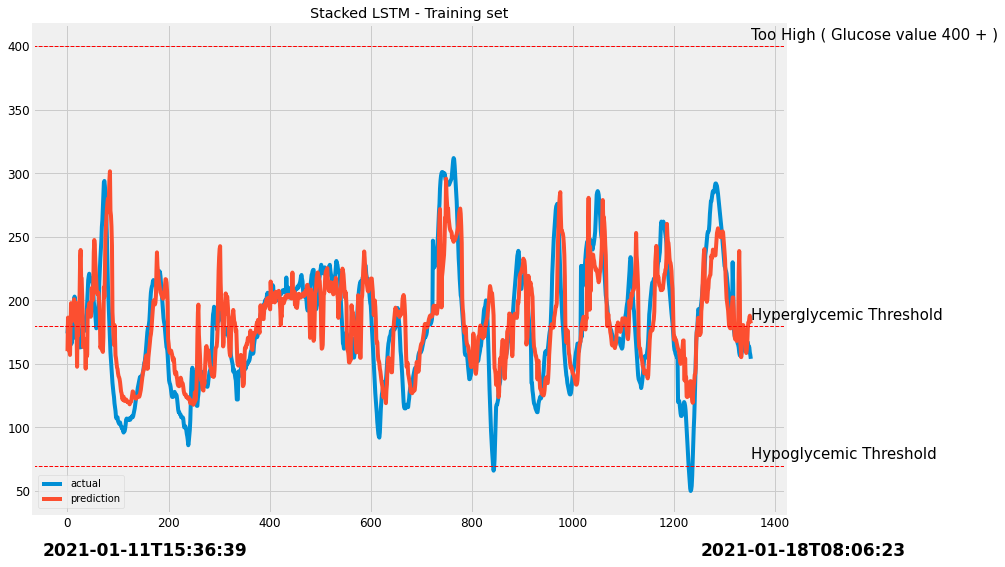

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_60 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  37.32752686929873


#### Validation

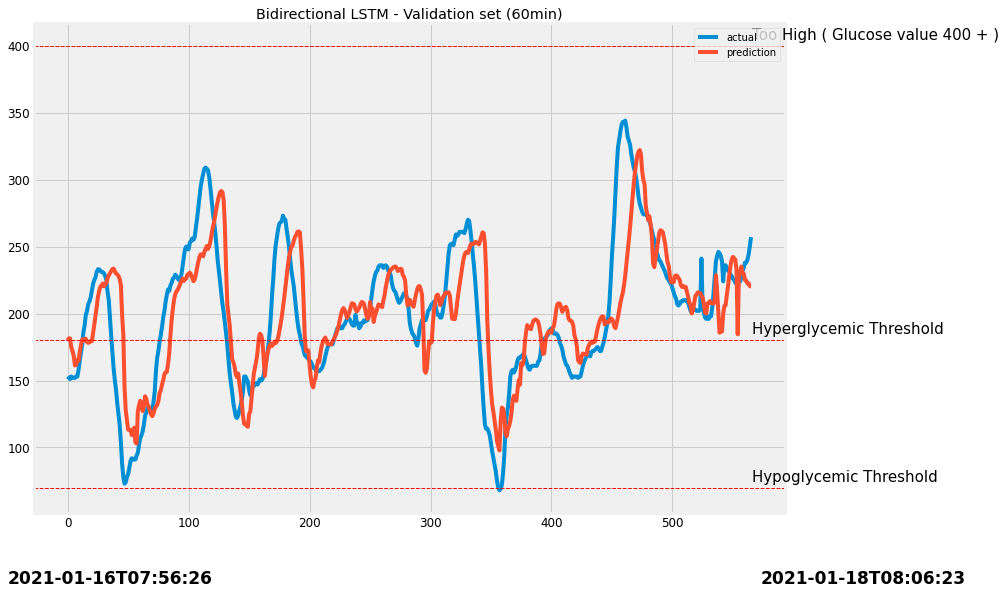

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

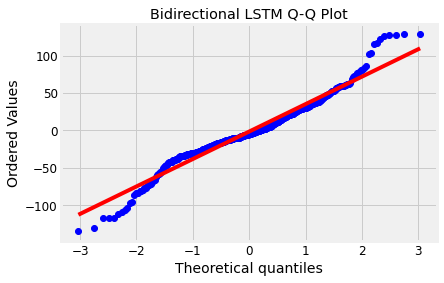

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  31.24961394377338


#### Train

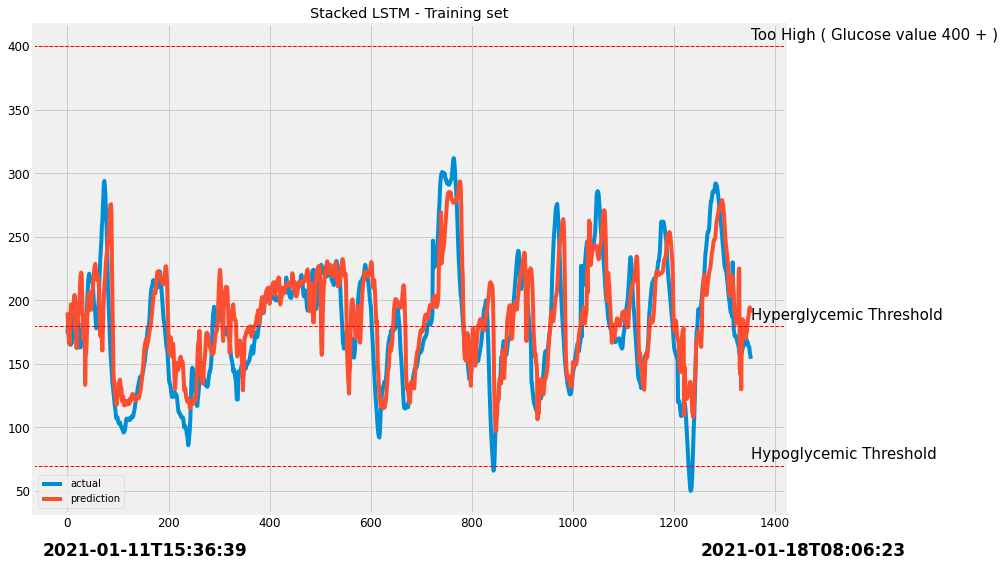

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_60 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  36.62526681779677


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

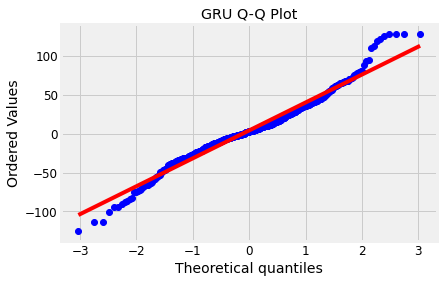

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

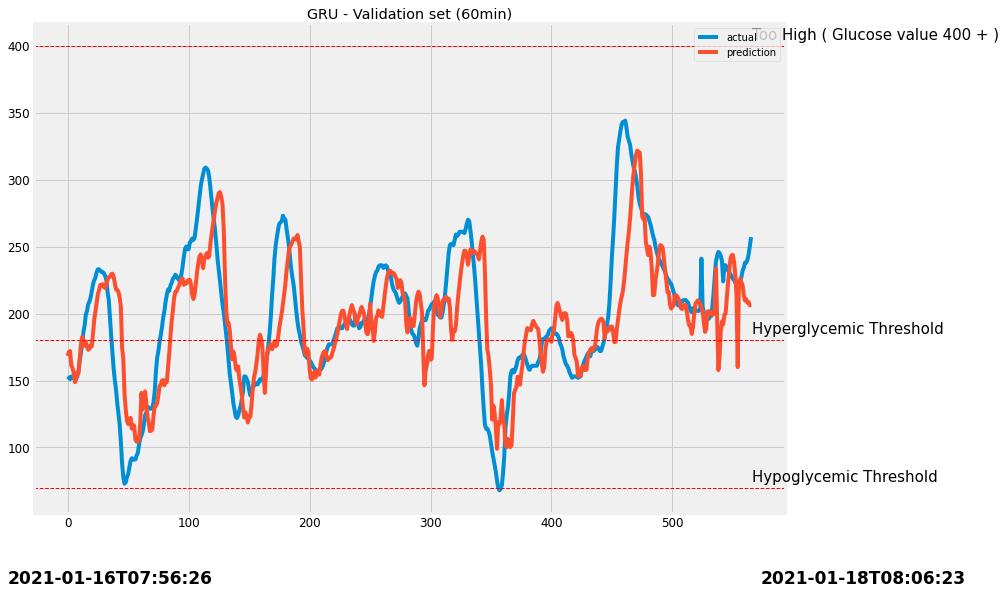

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_60 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (60min) Training set :  29.993642430523565


#### Train

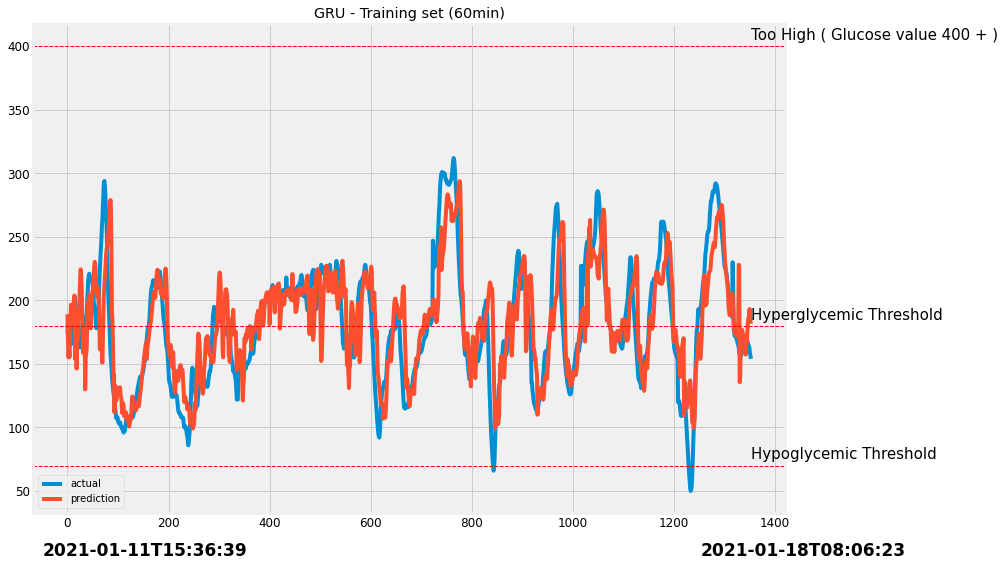

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 결과

In [ ]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60]


In [ ]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]

In [ ]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [ ]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result]

In [ ]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result]

In [ ]:
val_result_list

[[11.092902411459663, 20.92321356849146, 37.6520974374573],
 [9.981026897745885, 20.331703207799386, 37.03666706718292],
 [9.935383265476062, 19.897635236929553, 38.39375720069384],
 [9.664783766507409, 20.439508664629372, 37.32752686929873],
 [10.311455562463658, 19.171961096400324, 36.62526681779677]]

In [ ]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

15 MIN     30 MIN     60 MIN
RNN                 11.092902  20.923214  37.652097
LSTM                 9.981027  20.331703  37.036667
Stacked LSTM         9.935383  19.897635  38.393757
Bidirectional LSTM   9.664784  20.439509  37.327527
GRU                 10.311456  19.171961  36.625267

In [ ]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

15 MIN     30 MIN     60 MIN
RNN                 10.733623  19.196304  32.074008
LSTM                 9.412668  17.725680  31.509319
Stacked LSTM         8.902615  16.915467  32.567557
Bidirectional LSTM   9.353847  17.545297  31.249614
GRU                  9.670611  17.242503  29.993642

## CNN LSTM